In [5]:
# Acronym Matching Analysis Notebook

# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
import re
from Levenshtein import jaro_winkler, distance as levenshtein_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import jellyfish
from fuzzywuzzy import fuzz
import string
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Cell 2: Text Preprocessing Functions
def preprocess_text(text):
    """Basic text preprocessing: lowercase and remove special characters"""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def get_bigrams(text):
    """Generate character bigrams from text"""
    text = preprocess_text(text)
    return [text[i:i+2] for i in range(len(text)-1)]

# Text Preprocessing Functions Explanation

```python
def preprocess_text(text):
    """Basic text preprocessing: lowercase and remove special characters"""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def get_bigrams(text):
    """Generate character bigrams from text"""
    text = preprocess_text(text)
    return [text[i:i+2] for i in range(len(text)-1)]
```

## Function 1: `preprocess_text(text)`

This function performs essential text normalization before similarity calculations:

1. **Type Conversion**: Converts the input to a string with `str(text)` to ensure the function works even if non-string values are passed
2. **Lowercase Conversion**: Transforms all text to lowercase with `.lower()` to make comparisons case-insensitive
3. **Special Character Removal**: Uses regular expression `re.sub(r'[^\w\s]', '', text)` to:
   - Keep only word characters (`\w` = letters, digits, underscores)
   - Keep whitespace (`\s`)
   - Remove all punctuation and special characters

**Example:**
```
Input:  "Bank of America (BoA)!"
Output: "bank of america boa"
```

## Function 2: `get_bigrams(text)`

This function creates character-level bigrams (pairs of adjacent characters):

1. **Preprocessing**: First calls `preprocess_text()` to clean and normalize the input text
2. **Bigram Generation**: Uses list comprehension to create all consecutive character pairs:
   - `[text[i:i+2] for i in range(len(text)-1)]` iterates through the text
   - For each position `i`, it extracts the substring from position `i` to `i+2` (two characters)
   - Stops at `len(text)-1` to avoid going beyond the string's end

**Example:**
```
Input:  "McDonald's"
After preprocessing: "mcdonalds"
Output bigrams: ["mc", "cd", "do", "on", "na", "al", "ld", "ds"]
```

### Why These Functions Matter for Acronym Matching

- **Consistent Comparison**: Preprocessing ensures fair comparison regardless of capitalization or punctuation
- **Character-Level Analysis**: Bigrams capture character-level patterns that help identify similarity even with spelling variations
- **Fuzzy Matching Support**: Enables the Jaccard Bigram similarity metric that measures overlap between character pairs, making it useful for detecting partial acronym matches

These functions form the foundation for more sophisticated string similarity algorithms used in the acronym matching process.ithms used in the acronym matching process.

In [72]:
# 1. Jaro-Winkler similarity
def calc_jaro_winkler(str1, str2):
    """
    Reimplemented Jaro-Winkler to match the Scala implementation's behavior
    including the matchingscore wrapper logic
    """
    # Handle null values
    if str1 is None or str2 is None:
        return 0.0
    
    # Convert to strings (if they're not already)
    str1 = str(str1)
    str2 = str(str2)
    
    # Trim whitespace and convert to uppercase (as done in Scala code)
    str1 = str1.strip().upper()
    str2 = str2.strip().upper()
    
    # Check if strings are empty
    if not str1 or not str2:
        return 0.0
    
    # THIS IS THE KEY DIFFERENCE: Check if one string contains the other
    # This is from the matchingscore function in the Scala code
    if str1 in str2 or str2 in str1:
        return 1.0
    
    # If we get here, calculate standard Jaro-Winkler score
    # Implementation to match Scala's specific algorithm:
    
    # First calculate Jaro distance
    def jaro_distance(s1, s2):
        if s1 == s2:
            return 1.0
            
        len1 = len(s1)
        len2 = len(s2)
        
        if len1 == 0 or len2 == 0:
            return 0.0
            
        max_dist = max(len1, len2) // 2 - 1
        if max_dist < 0:
            max_dist = 0
            
        matches = 0
        hash_s1 = [0] * len1
        hash_s2 = [0] * len2
        
        for i in range(len1):
            start = max(0, i - max_dist)
            end = min(i + max_dist + 1, len2)
            
            for j in range(start, end):
                if s1[i] == s2[j] and hash_s2[j] == 0:
                    hash_s1[i] = 1
                    hash_s2[j] = 1
                    matches += 1
                    break
        
        if matches == 0:
            return 0.0
        
        # Count transpositions
        t = 0
        point = 0
        
        for i in range(len1):
            if hash_s1[i] == 1:
                while hash_s2[point] == 0:
                    point += 1
                if s1[i] != s2[point]:
                    t += 1
                point += 1
        
        t = t // 2
        
        return ((matches / len1) + (matches / len2) + ((matches - t) / matches)) / 3.0
    
    # Calculate basic Jaro distance
    jaro_dist = jaro_distance(str1, str2)
    
    # Apply Winkler modification for common prefixes
    # Only if Jaro distance > 0.7 (as in Scala code)
    if jaro_dist > 0.7:
        # Count matching prefix characters (up to 4)
        prefix = 0
        for i in range(min(len(str1), len(str2))):
            if str1[i] == str2[i]:
                prefix += 1
            else:
                break
        prefix = min(4, prefix)
        
        # Apply the 0.1 scaling factor for the prefix adjustment
        jaro_dist += 0.1 * prefix * (1 - jaro_dist)
    
    return jaro_dist


## Jaro-Winkler Similarity Algorithm: Theoretical Overview

### Fundamental Concept

The Jaro-Winkler similarity algorithm is a sophisticated string matching technique designed to quantify the resemblance between two strings, with a particular emphasis on measuring the similarity of names and short text sequences. Developed by Matthew A. Jaro and modified by William E. Winkler, this algorithm provides a nuanced approach to string comparison that goes beyond simple character-by-character matching.

### Core Components of the Algorithm

#### 1. Matching Mechanism

The algorithm's core principle revolves around identifying matching characters between two strings while considering their positional proximity. Unlike naive string comparison methods, Jaro-Winkler introduces a concept of a "matching window" that allows for approximate character matching within a reasonable distance.

#### 2. Similarity Calculation Principles

The similarity score is computed through a multi-step process that evaluates:
- Number of matching characters
- Character transpositions
- Common prefix characteristics

#### 3. Scoring Methodology

The algorithm generates a similarity score ranging from 0 to 1, where:
- 0 represents completely dissimilar strings
- 1 represents identical strings
- Intermediate values indicate partial similarities

### Mathematical Framework

The Jaro-Winkler similarity is calculated using a composite formula with two primary components:

1. **Jaro Similarity Base Calculation**
   - Measures the number of matching characters
   - Accounts for character transpositions
   - Provides a baseline similarity metric

   ```
   Jaro(s1, s2) = (m/|s1| + m/|s2| + (m - t)/m) / 3
   
   Where:
   - m = number of matching characters
   - |s1|, |s2| = lengths of strings
   - t = number of transpositions
   ```

2. **Winkler Prefix Modification**
   - Enhances similarity for strings with common prefixes
   - Adds a scaling factor to reward matching initial characters

   ```
   Winkler Boost = p * l * (1 - Jaro)
   
   Where:
   - p = prefix scaling factor (typically 0.1)
   - l = length of common prefix (maximum 4 characters)
   ```

### Algorithmic Characteristics

#### Matching Strategy
- Identifies characters that appear in both strings
- Allows matches within a specified proximity
- Tolerates slight positional variations

#### Transposition Handling
- Detects and penalizes character order differences
- Provides a more sophisticated matching approach compared to simple edit distance methods

#### Prefix Sensitivity
- Gives additional weight to strings with matching initial characters
- Particularly effective for name and short text comparisons

### Strengths in String Matching

1. **Robust Typo Tolerance**
   - Handles minor spelling variations
   - Accommodates small character displacement

2. **Prefix Importance**
   - Recognizes the significance of string beginnings
   - Provides higher scores for strings with similar initial segments

3. **Versatile Application**
   - Effective across various domains
   - Particularly powerful in:
     * Name matching
     * Record linkage
     * Fuzzy search implementations

### Limitations and Considerations

1. Performance decreases with very long strings
2. May not capture semantic similarities
3. Sensitive to character transposition patterns
4. Requires careful parameter tuning for optimal results

### Practical Implementation Considerations

- Best suited for short to medium-length strings
- Recommended for scenarios involving:
  * Personal name comparisons
  * Address matching
  * Duplicate record detection
- Performance complexity increases quadratically with string length

### Theoretical Significance

The Jaro-Winkler algorithm represents a sophisticated approach to string similarity that transcends simple character-by-character comparison. By incorporating sophisticated matching and prefix-weighting mechanisms, it provides a nuanced method for assessing string resemblance that reflects the complex nature of human-generated text variations.

### Mathematical Foundations

The algorithm's design is rooted in information theory and pattern matching principles, offering a probabilistic approach to string similarity that acknowledges the inherent complexity of textual variations.

In [75]:
# 2. Damerau-Levenshtein similarity (normalized)
def calc_damerau_levenshtein(str1, str2):
    """Calculate normalized Damerau-Levenshtein similarity"""
    max_len = max(len(str1), len(str2))
    if max_len == 0:
        return 1.0
    return 1 - levenshtein_distance(str1, str2) / max_len

## Damerau-Levenshtein Similarity Algorithm: Theoretical Overview

### Fundamental Concept

The Damerau-Levenshtein distance is an advanced string comparison metric that extends the classic Levenshtein distance by introducing a critical enhancement: the ability to handle character transpositions. Named after Frederick J. Damerau, this algorithm provides a sophisticated approach to measuring the similarity between two strings by quantifying the minimal number of operations required to transform one string into another.

### Core Principles of the Algorithm

#### 1. Operational Transformations

The algorithm considers four fundamental edit operations:
- **Insertion**: Adding a character to the string
- **Deletion**: Removing a character from the string
- **Substitution**: Replacing one character with another
- **Transposition**: Swapping adjacent characters

#### 2. Distinguishing Feature

Unlike the standard Levenshtein distance, Damerau-Levenshtein uniquely recognizes transpositions as a single edit operation, which more accurately reflects human error patterns in text.

### Mathematical Framework

#### Distance Calculation
```
Damerau-Levenshtein(s1, s2) = Minimum number of edit operations
```

#### Similarity Normalization
```python
Normalized Similarity = 1 - (Damerau-Levenshtein Distance / Maximum String Length)
```

### Algorithmic Mechanics

1. **Edit Distance Computation**
   - Dynamically builds a matrix of minimal edit operations
   - Tracks transformations between source and target strings
   - Considers all possible edit sequences

2. **Transposition Handling**
   - Uniquely identifies adjacent character swaps
   - Treats transpositions more efficiently than standard Levenshtein
   - Reflects real-world typing and transcription errors

### Practical Implementation Insights

```python
def calc_damerau_levenshtein(str1, str2):
    # Normalize against maximum string length
    max_len = max(len(str1), len(str2))
    
    # Handle empty string edge case
    if max_len == 0:
        return 1.0
    
    # Calculate normalized distance
    return 1 - levenshtein_distance(str1, str2) / max_len
```

### Theoretical Significance

#### Key Characteristics
- Distance metric ranges from 0 to 1
- 0 indicates completely different strings
- 1 indicates identical strings
- Intermediate values represent partial similarities

### Comparative Advantages

1. **Enhanced Error Detection**
   - More accurately models human typing errors
   - Captures nuanced string variations
   - Particularly effective for:
     * Spell checking
     * Name matching
     * OCR error correction

2. **Complexity and Precision**
   - Provides a more refined similarity measure
   - Handles complex string transformation scenarios
   - Computationally more intensive than simple matching algorithms

### Limitations and Considerations

1. Computational complexity increases with string length
2. Performance may degrade for extremely long strings
3. Requires careful parameter tuning
4. Less effective for semantically different strings with similar character compositions

### Domain Applications

- Spell checking systems
- Plagiarism detection
- Genetic sequence alignment
- Record matching and deduplication
- Search suggestion mechanisms

### Theoretical Complexity

#### Time Complexity
- O(m*n), where m and n are string lengths
- Quadratic growth with string size

#### Space Complexity
- O(m*n) dynamic programming matrix
- Requires additional memory proportional to input string lengths

### Mathematical Foundations

Rooted in information theory and string transformation principles, the Damerau-Levenshtein algorithm provides a probabilistic approach to quantifying string similarity that acknowledges the intricate nature of textual variations.

### Normalization Strategy

The normalization process ensures that:
- Similarity scores are independent of string length
- Comparisons remain consistent across different string sizes
- Results are interpretable on a standardized 0-1 scale

### Comparative Analysis

Compared to standard Levenshtein distance, Damerau-Levenshtein offers:
- More nuanced error detection
- Better modeling of human error patterns
- Improved handling of adjacent character swaps

In [78]:

# 3. TF-IDF Cosine similarity
def calc_tfidf_cosine(str1, str2):
    """Calculate TF-IDF cosine similarity"""
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform([str1, str2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]


## TF-IDF Cosine Similarity Algorithm: Theoretical Overview

### Fundamental Concept

The TF-IDF (Term Frequency-Inverse Document Frequency) Cosine Similarity is a sophisticated text analysis technique that combines two powerful mathematical concepts to measure the semantic similarity between text strings. This algorithm transforms text into numerical vectors, enabling quantitative comparison of textual content beyond simple character matching.

### Core Components of the Algorithm

#### 1. Term Frequency (TF)
- Measures how frequently a term appears in a document
- Captures the local importance of a term within a specific text
- Represents the raw count of a term's occurrences

#### 2. Inverse Document Frequency (IDF)
- Assesses the global importance of a term across a collection of documents
- Reduces the weight of commonly occurring terms
- Highlights unique or distinctive terms

#### 3. Cosine Similarity
- Measures the cosine of the angle between two vectors
- Provides a normalized similarity score
- Independent of vector magnitude

### Mathematical Framework

```
TF-IDF = TF * IDF

Cosine Similarity = (A · B) / (||A|| * ||B||)

Where:
- A, B are vector representations of strings
- · represents dot product
- ||A|| represents vector magnitude
```

### Algorithmic Mechanics

1. **Vectorization Process**
   - Breaks strings into character n-grams
   - Converts text into numerical vector representations
   - Captures local and global term significance

2. **Weighting Mechanism**
   - Assigns higher weights to distinctive character sequences
   - Downweights common character combinations
   - Creates a nuanced vector representation

### Practical Implementation Insights

```python
def calc_tfidf_cosine(str1, str2):
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        analyzer='char',     # Character-level analysis
        ngram_range=(1, 2)   # 1 and 2-character n-grams
    )
    
    # Transform strings into TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform([str1, str2])
    
    # Calculate cosine similarity
    return cosine_similarity(
        tfidf_matrix[0:1],   # First string vector
        tfidf_matrix[1:2]    # Second string vector
    )[0][0]
```

### Key Algorithmic Features

1. **N-gram Analysis**
   - Captures local character patterns
   - Uses both single characters and character pairs
   - Provides more contextual similarity measurement

2. **Vector Space Representation**
   - Transforms text into multi-dimensional vectors
   - Enables mathematical similarity computation
   - Preserves subtle textual characteristics

### Theoretical Significance

#### Similarity Scoring
- Scores range from 0 to 1
- 0 indicates completely dissimilar strings
- 1 represents identical strings
- Intermediate values reflect partial similarities

### Domain Applications

- Text classification
- Document retrieval
- Plagiarism detection
- Search engine matching
- Record linkage
- Fuzzy string matching

### Computational Characteristics

#### Strengths
- Captures semantic relationships
- Handles variable-length strings
- Provides nuanced similarity measurement

#### Limitations
- Computationally intensive
- Performance decreases with very long strings
- Sensitive to character sequence variations

### Advanced Considerations

1. **Ngram Configuration**
   - Character-level analysis allows flexible matching
   - (1, 2) range captures both individual characters and character pairs
   - Provides balanced similarity assessment

2. **Vectorization Strategy**
   - Converts text into numerical representation
   - Enables complex similarity comparisons
   - Independent of linguistic context

### Comparative Analysis

Compared to simple string matching algorithms, TF-IDF Cosine Similarity offers:
- More sophisticated similarity assessment
- Semantic-aware comparison
- Robust handling of textual variations

### Mathematical Foundations

Rooted in information retrieval and natural language processing principles, the algorithm provides a probabilistic approach to quantifying string similarity that acknowledges the complex nature of textual representation.

### Performance Considerations

#### Time Complexity
- O(n^2) for vector computation
- Increases quadratically with string length

#### Space Complexity
- O(n) vector storage
- Proportional to input string characteristics

### Theoretical Implications

The TF-IDF Cosine Similarity algorithm represents an advanced mathematical approach to text comparison that transcends traditional character-matching techniques, offering a sophisticated method for assessing textual resemblance through vectorized representation and advanced weighting mechanisms.

In [81]:

# 4. Jaccard Bigram similarity
def calc_jaccard_bigram(str1, str2):
    """Calculate Jaccard similarity on character bigrams"""
    set1 = set(get_bigrams(str1))
    set2 = set(get_bigrams(str2))
    
    if not set1 and not set2:
        return 1.0
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    return intersection / union


## Jaccard Bigram Similarity Algorithm: Theoretical Overview

### Fundamental Concept

The Jaccard Bigram Similarity is an elegant and powerful string comparison algorithm that measures the similarity between two strings by analyzing their character bigram compositions. This method provides a sophisticated approach to quantifying textual resemblance through set-based intersectional analysis.

### Core Principles of the Algorithm

#### 1. Bigram Decomposition
- Breaks strings into consecutive two-character sequences
- Captures local character patterns
- Provides a granular representation of string structure

#### 2. Set-Based Similarity Measurement
- Converts bigram sequences into sets
- Compares sets using intersection and union
- Quantifies similarity through set-based operations

### Mathematical Framework

```
Jaccard Similarity = |Intersection| / |Union|

Where:
- |Intersection| = Number of common bigrams
- |Union| = Total number of unique bigrams
- Result ranges from 0 to 1
```

### Algorithmic Mechanics

1. **Bigram Generation**
   - Extracts consecutive two-character sequences
   - Creates set representations of string components
   - Handles strings of varying lengths

2. **Similarity Computation**
   - Calculates intersection of bigram sets
   - Determines total unique bigrams
   - Computes normalized similarity score

### Practical Implementation Insights

```python
def calc_jaccard_bigram(str1, str2):
    # Generate bigram sets
    set1 = set(get_bigrams(str1))
    set2 = set(get_bigrams(str2))
    
    # Handle empty string edge case
    if not set1 and not set2:
        return 1.0
    
    # Compute Jaccard similarity
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    return intersection / union
```

### Theoretical Significance

#### Key Characteristics
- Similarity score ranges from 0 to 1
- 0 indicates completely different strings
- 1 represents identical bigram compositions
- Intermediate values reflect partial similarities

### Algorithmic Advantages

1. **Robust Pattern Recognition**
   - Captures local character relationships
   - Handles variations in string structure
   - Provides nuanced similarity assessment

2. **Computational Efficiency**
   - Linear time complexity
   - Set-based operations enable quick comparisons
   - Minimal memory overhead

### Domain Applications

- Fuzzy string matching
- Spelling correction
- Plagiarism detection
- Search suggestion systems
- Data deduplication
- Name matching

### Comparative Analysis

Compared to character-by-character matching, Jaccard Bigram Similarity offers:
- More contextual similarity assessment
- Resilience to character transpositions
- Flexible matching capabilities

### Detailed Algorithmic Workflow

1. **Preprocessing**
   - Normalize input strings
   - Remove special characters
   - Convert to lowercase

2. **Bigram Extraction**
   - Generate consecutive two-character sequences
   - Create set representations
   - Example: 
     * "hello" → {"he", "el", "ll", "lo"}
     * "hallo" → {"ha", "al", "ll", "lo"}

3. **Similarity Computation**
   - Identify common bigrams
   - Calculate intersection and union
   - Normalize result

### Computational Characteristics

#### Strengths
- Handles variable-length strings
- Captures local character patterns
- Computationally lightweight

#### Limitations
- Less effective for very short strings
- May miss semantic similarities
- Sensitive to character order variations

### Performance Considerations

#### Time Complexity
- O(n) for bigram generation
- O(1) for set operations
- Efficient for most string lengths

#### Space Complexity
- O(n) for storing bigram sets
- Minimal memory requirements

### Mathematical Foundations

Rooted in set theory and information retrieval principles, the Jaccard Bigram Similarity provides a probabilistic approach to quantifying string similarity that acknowledges the intricate nature of textual composition.

### Advanced Considerations

1. **Normalization Strategies**
   - Handles empty string scenarios
   - Provides consistent scoring mechanisms
   - Ensures robust comparison across varied inputs

2. **Flexible Configuration**
   - Adaptable to different n-gram sizes
   - Supports custom preprocessing techniques
   - Enables domain-specific tuning

### Theoretical Implications

The Jaccard Bigram Similarity algorithm represents an innovative mathematical approach to string comparison that transcends traditional matching techniques, offering a sophisticated method for assessing textual resemblance through set-theoretic principles and local pattern analysis.

In [84]:

# 5. Soundex Match (binary score)
def calc_soundex_match(str1, str2):
    """Calculate binary Soundex match (1 if match, 0 if not)"""
    soundex1 = jellyfish.soundex(str1)
    soundex2 = jellyfish.soundex(str2)
    return 1 if soundex1 == soundex2 else 0


## Soundex Matching Algorithm: Theoretical Overview

### Fundamental Concept

The Soundex algorithm is a phonetic indexing technique designed to encode surnames with similar pronunciations to the same representation, enabling effective name matching across variations in spelling. Developed originally by Robert C. Russell and modified by Donald Knuth, this algorithm provides a robust method for identifying names that sound alike, regardless of their exact spelling.

### Core Principles of the Algorithm

#### 1. Phonetic Encoding
- Converts words into a standardized phonetic code
- Focuses on consonant sounds
- Minimizes the impact of vowel and spelling variations

#### 2. Encoding Mechanism
- Preserves the first letter of the original name
- Translates subsequent consonants into numeric codes
- Reduces complex names to a simple, consistent format

### Mathematical Framework

#### Soundex Encoding Rules
1. Keep the first letter of the name
2. Replace subsequent consonants with numeric codes
3. Remove vowels and certain consonants
4. Truncate or pad the code to a standard length

### Algorithmic Mechanics

1. **Preprocessing**
   - Convert name to uppercase
   - Retain first letter
   - Encode remaining consonants

2. **Consonant Encoding**
   ```
   Encoding Map:
   - B, F, P, V → 1
   - C, G, J, K, Q, S, X, Z → 2
   - D, T → 3
   - L → 4
   - M, N → 5
   - R → 6
   ```

3. **Code Generation**
   - Remove duplicate adjacent codes
   - Pad or truncate to standard length (typically 4 characters)

### Practical Implementation Insights

```python
def calc_soundex_match(str1, str2):
    # Generate Soundex codes
    soundex1 = jellyfish.soundex(str1)
    soundex2 = jellyfish.soundex(str2)
    
    # Binary matching
    return 1 if soundex1 == soundex2 else 0
```

### Theoretical Significance

#### Key Characteristics
- Binary matching (0 or 1)
- Focuses on phonetic similarity
- Independent of spelling variations
- Handles name variations effectively

### Algorithmic Advantages

1. **Pronunciation-Based Matching**
   - Captures phonetic similarities
   - Handles spelling variations
   - Effective for name matching

2. **Computational Efficiency**
   - Fast encoding process
   - Constant-time comparison
   - Minimal computational overhead

### Domain Applications

- Genealogical research
- Name matching systems
- Spell checking
- Database deduplication
- Search suggestion mechanisms
- Immigrant name matching

### Detailed Encoding Example

```
Name: "Robert"
Soundex Process:
1. First letter: R
2. Encode consonants: 
   - R → 6
   - B → 1
   - Consecutive duplicates removed
3. Final Soundex Code: R613
```

### Comparative Analysis

Compared to traditional string matching, Soundex offers:
- Phonetic similarity assessment
- Robust handling of spelling variations
- Cultural name variation support

### Computational Characteristics

#### Strengths
- Language-independent phonetic matching
- Handles complex name variations
- Simple and fast implementation

#### Limitations
- Binary (exact/non-exact) matching
- Less effective for very short names
- Limited to English language phonetics

### Performance Considerations

#### Time Complexity
- O(1) for encoding
- O(1) for comparison
- Extremely efficient

#### Space Complexity
- Minimal memory requirements
- Constant-space representation

### Mathematical Foundations

Rooted in linguistic phonetic principles, Soundex provides a probabilistic approach to name matching that acknowledges the complex nature of linguistic variation.

### Advanced Considerations

1. **Multilingual Adaptations**
   - Original algorithm primarily designed for English
   - Modified versions exist for other languages
   - Requires careful linguistic tuning

2. **Matching Strategies**
   - Binary matching limits nuanced comparisons
   - Useful for initial filtering
   - Recommended to combine with other similarity metrics

### Theoretical Implications

The Soundex algorithm represents an innovative approach to name matching that transcends traditional character-based comparison, offering a sophisticated method for assessing name similarity through phonetic encoding and sound-based principles.

### Practical Recommendations

1. Use as an initial matching filter
2. Combine with other similarity algorithms
3. Validate results in domain-specific contexts
4. Understand cultural and linguistic limitations

### Linguistic Insights

The algorithm acknowledges that names can be spelled differently while maintaining similar pronunciation, providing a systematic approach to capturing these phonetic nuances through a standardized encoding mechanism.

In [87]:

# 6. Token Sort Ratio
def calc_token_sort_ratio(str1, str2):
    """Calculate token sort ratio using fuzzywuzzy"""
    return fuzz.token_sort_ratio(str1, str2) / 100.0


## Token Sort Ratio Algorithm: Theoretical Overview

### Fundamental Concept

The Token Sort Ratio is an advanced string matching technique designed to compare the similarity of strings by evaluating their constituent tokens (words) in a normalized, order-independent manner. Developed as part of the FuzzyWuzzy library, this algorithm provides a sophisticated approach to measuring string similarity that transcends traditional character-by-character comparison.

### Core Principles of the Algorithm

#### 1. Token-Based Decomposition
- Breaks strings into individual words (tokens)
- Removes sensitivity to word order
- Enables flexible string comparison

#### 2. Normalization Strategy
- Standardizes token representation
- Handles variations in word arrangement
- Provides consistent similarity measurement

### Mathematical Framework

```
Token Sort Ratio = Similarity Score / 100

Where:
- Similarity Score ranges from 0 to 100
- Normalized to 0-1 range for consistent interpretation
```

### Algorithmic Mechanics

1. **Preprocessing**
   - Tokenize input strings
   - Sort tokens alphabetically
   - Normalize token representation

2. **Similarity Computation**
   - Compare sorted token sequences
   - Calculate matching percentage
   - Normalize to standard scale

### Practical Implementation Insights

```python
def calc_token_sort_ratio(str1, str2):
    # Utilize FuzzyWuzzy's token sort ratio
    # Normalize to 0-1 range by dividing by 100
    return fuzz.token_sort_ratio(str1, str2) / 100.0
```

### Detailed Algorithmic Workflow

1. **String Tokenization**
   - Split strings into individual words
   - Remove punctuation and special characters
   - Standardize token representation

2. **Token Sorting**
   - Arrange tokens in alphabetical order
   - Create normalized token sequences

3. **Similarity Calculation**
   - Compare sorted token sequences
   - Compute matching percentage
   - Handle variations in word arrangement

### Theoretical Significance

#### Key Characteristics
- Similarity score ranges from 0 to 1
- 0 indicates completely different strings
- 1 represents identical token compositions
- Intermediate values reflect partial similarities

### Algorithmic Advantages

1. **Order-Independent Matching**
   - Handles word rearrangements
   - Provides flexible string comparison
   - Robust against syntactic variations

2. **Comprehensive Similarity Assessment**
   - Captures semantic relationships
   - Tolerates word order differences
   - Effective for complex string comparisons

### Domain Applications

- Fuzzy string matching
- Search suggestion systems
- Plagiarism detection
- Document similarity analysis
- Record linkage
- Name matching

### Comparative Analysis

Compared to traditional string matching, Token Sort Ratio offers:
- Flexibility in word arrangement
- Semantic-aware similarity assessment
- Robust handling of syntactic variations

### Computational Characteristics

#### Strengths
- Handles variable-length strings
- Captures semantic similarities
- Computationally efficient

#### Limitations
- Less effective for very short strings
- May miss nuanced contextual differences
- Sensitive to token composition

### Performance Considerations

#### Time Complexity
- O(n log n) due to token sorting
- Efficient for most practical applications
- Minimal computational overhead

#### Space Complexity
- O(n) for token storage
- Minimal memory requirements

### Mathematical Foundations

Rooted in information retrieval and natural language processing principles, the Token Sort Ratio provides a probabilistic approach to quantifying string similarity that acknowledges the complex nature of textual composition.

### Advanced Considerations

1. **Normalization Techniques**
   - Handles case sensitivity
   - Removes punctuation and special characters
   - Provides consistent token representation

2. **Flexible Configuration**
   - Adaptable to different tokenization strategies
   - Supports custom preprocessing techniques
   - Enables domain-specific tuning

### Practical Examples

```python
# Demonstration of Token Sort Ratio
print(calc_token_sort_ratio("hello world", "world hello"))  # High similarity
print(calc_token_sort_ratio("python programming", "programming in python"))  # High similarity
print(calc_token_sort_ratio("completely different", "totally unrelated"))  # Low similarity
```

### Linguistic Insights

The algorithm acknowledges that meaningful text can be expressed in multiple syntactic arrangements, providing a systematic approach to capturing these semantic nuances through token-based comparison.

### Theoretical Implications

The Token Sort Ratio algorithm represents an innovative mathematical approach to string comparison that transcends traditional matching techniques, offering a sophisticated method for assessing textual resemblance through flexible, order-independent token analysis.

### Recommended Usage Strategies

1. Use as part of a comprehensive similarity assessment
2. Combine with other matching algorithms
3. Configure tokenization for specific domain requirements
4. Validate results in context-specific scenarios

In [90]:

# 7. Contains Ratio
def calc_contains_ratio(str1, str2):
    """Calculate contains ratio - how much of the shorter string is in the longer one"""
    str1 = str1.lower()
    str2 = str2.lower()
    
    if len(str1) <= len(str2):
        shorter, longer = str1, str2
    else:
        shorter, longer = str2, str1
    
    matches = sum(1 for char in shorter if char in longer)
    return matches / len(shorter) if shorter else 1.0


## Contains Ratio Similarity Algorithm: Theoretical Overview

### Fundamental Concept

The Contains Ratio algorithm is an innovative string similarity measurement technique that quantifies the degree to which characters from one string are present within another. This approach provides a unique perspective on string similarity by focusing on character containment rather than traditional sequential matching.

### Core Principles of the Algorithm

#### 1. Character Containment Analysis
- Identifies character presence across strings
- Compares shorter string against longer string
- Measures proportional character overlap

#### 2. Normalization Strategy
- Converts strings to lowercase
- Ensures case-insensitive comparison
- Provides consistent similarity assessment

### Mathematical Framework

```
Contains Ratio = (Number of Matching Characters) / (Length of Shorter String)

Where:
- Matching Characters: Characters from shorter string found in longer string
- Result ranges from 0 to 1
- 1.0 indicates complete character containment
- 0.0 indicates no character overlap
```

### Algorithmic Mechanics

1. **Preprocessing**
   - Convert strings to lowercase
   - Determine shorter and longer strings
   - Normalize for case sensitivity

2. **Matching Computation**
   - Count characters from shorter string present in longer string
   - Calculate proportion of contained characters
   - Handle edge cases like empty strings

### Practical Implementation Insights

```python
def calc_contains_ratio(str1, str2):
    # Lowercase conversion for case-insensitive matching
    str1 = str1.lower()
    str2 = str2.lower()
    
    # Determine shorter and longer strings
    if len(str1) <= len(str2):
        shorter, longer = str1, str2
    else:
        shorter, longer = str2, str1
    
    # Count matching characters
    matches = sum(1 for char in shorter if char in longer)
    
    # Calculate and return containment ratio
    return matches / len(shorter) if shorter else 1.0
```

### Theoretical Significance

#### Key Characteristics
- Similarity score ranges from 0 to 1
- 0 indicates no character overlap
- 1 represents complete character containment
- Provides nuanced similarity assessment

### Algorithmic Advantages

1. **Flexible Matching**
   - Handles strings of different lengths
   - Captures partial string similarities
   - Independent of character sequence

2. **Computational Efficiency**
   - Linear time complexity
   - Minimal computational overhead
   - Simple and straightforward implementation

### Domain Applications

- Partial string matching
- Substring detection
- Fuzzy search algorithms
- Data validation
- Name variation analysis
- Pattern recognition

### Comparative Analysis

Compared to traditional string matching, Contains Ratio offers:
- Flexible character-level similarity assessment
- Length-independent comparison
- Simple and intuitive approach

### Computational Characteristics

#### Strengths
- Handles variable-length strings
- Case-insensitive matching
- Quick computation

#### Limitations
- Ignores character sequence
- Less effective for complex semantic matching
- May overestimate similarity for strings with common characters

### Performance Considerations

#### Time Complexity
- O(n), where n is length of shorter string
- Extremely efficient
- Constant-time character lookup

#### Space Complexity
- O(1) additional space
- Minimal memory requirements

### Mathematical Foundations

Rooted in set theory and character-level analysis, the Contains Ratio provides a probabilistic approach to quantifying string similarity that acknowledges the intricate nature of character distribution.

### Advanced Considerations

1. **Containment vs. Sequence**
   - Focuses on character presence
   - Disregards original character order
   - Provides unique similarity perspective

2. **Normalization Techniques**
   - Lowercase conversion
   - Handles case variations
   - Ensures consistent comparison

### Practical Examples

```python
# Demonstration of Contains Ratio
print(calc_contains_ratio("hello", "hello world"))  # Near-perfect match
print(calc_contains_ratio("python", "programming"))  # Partial match
print(calc_contains_ratio("abc", "xyz"))  # No match
```

### Linguistic Insights

The algorithm acknowledges that meaningful textual similarity can exist beyond strict sequential matching, providing a systematic approach to capturing character-level relationships.

### Theoretical Implications

The Contains Ratio algorithm represents an innovative approach to string comparison that transcends traditional matching techniques, offering a sophisticated method for assessing textual resemblance through character containment analysis.

### Recommended Usage Strategies

1. Use as complementary similarity metric
2. Combine with other matching algorithms
3. Validate results in specific domain contexts
4. Consider limitations in semantic matching

### Edge Case Handling

- Manages empty string scenarios
- Provides consistent 1.0 score for empty inputs
- Handles strings of disparate lengths
- Ensures robust performance across varied inputs

In [93]:

# 8. Fuzzy Matching with Levenshtein Distance
def calc_fuzzy_levenshtein(str1, str2, threshold=0.7):
    """Fuzzy matching using Levenshtein distance with a threshold"""
    max_len = max(len(str1), len(str2))
    if max_len == 0:
        return 1.0
    
    distance = levenshtein_distance(str1, str2)
    similarity = 1 - (distance / max_len)
    
    # Apply threshold - return similarity if above threshold, else 0
    return similarity if similarity >= threshold else similarity


## Fuzzy Levenshtein Distance Similarity Algorithm: Theoretical Overview

### Fundamental Concept

The Fuzzy Levenshtein Distance algorithm is an advanced string matching technique that quantifies the similarity between two strings by measuring the minimal number of single-character edits required to transform one string into another. This method introduces a sophisticated approach to handling textual variations through a nuanced similarity scoring mechanism.

### Core Principles of the Algorithm

#### 1. Edit Distance Computation
- Calculates minimal transformational operations
- Identifies fundamental string differences
- Provides granular similarity assessment

#### 2. Threshold-Based Matching
- Introduces configurable similarity threshold
- Enables flexible matching criteria
- Allows fine-tuned similarity detection

### Mathematical Framework

```
Fuzzy Similarity = 1 - (Levenshtein Distance / Maximum String Length)

Where:
- Levenshtein Distance: Minimal edit operations
- Maximum String Length: Normalization factor
- Threshold: Configurable matching sensitivity
```

### Algorithmic Mechanics

1. **Distance Calculation**
   - Compute edit operations between strings
   - Determine minimal transformation cost
   - Normalize against string length

2. **Similarity Transformation**
   - Convert distance to similarity score
   - Apply configurable threshold
   - Provide flexible matching mechanism

### Practical Implementation Insights

```python
def calc_fuzzy_levenshtein(str1, str2, threshold=0.7):
    # Handle empty string scenario
    max_len = max(len(str1), len(str2))
    if max_len == 0:
        return 1.0
    
    # Calculate Levenshtein distance
    distance = levenshtein_distance(str1, str2)
    
    # Compute normalized similarity
    similarity = 1 - (distance / max_len)
    
    # Apply threshold-based matching
    return similarity if similarity >= threshold else similarity
```

### Theoretical Significance

#### Key Characteristics
- Similarity score ranges from 0 to 1
- 0 indicates completely different strings
- 1 represents identical strings
- Threshold enables configurable matching sensitivity

### Algorithmic Advantages

1. **Comprehensive Similarity Assessment**
   - Captures subtle string variations
   - Handles multiple transformation scenarios
   - Provides nuanced matching capabilities

2. **Flexible Matching Mechanism**
   - Configurable threshold
   - Adaptable to different matching requirements
   - Supports domain-specific matching strategies

### Domain Applications

- Spell checking systems
- Duplicate detection
- Search suggestion mechanisms
- Data cleaning
- Record matching
- Name normalization
- Plagiarism detection

### Comparative Analysis

Compared to traditional string matching, Fuzzy Levenshtein offers:
- Sophisticated edit distance computation
- Normalized similarity scoring
- Threshold-based matching flexibility

### Computational Characteristics

#### Strengths
- Handles variable-length strings
- Captures subtle textual variations
- Computationally efficient

#### Limitations
- Performance decreases with very long strings
- Threshold selection requires careful tuning
- Less effective for semantically complex texts

### Performance Considerations

#### Time Complexity
- O(m*n), where m and n are string lengths
- Quadratic growth with input size
- Efficient for moderate-length strings

#### Space Complexity
- O(m*n) for distance matrix
- Proportional to input string lengths

### Mathematical Foundations

Rooted in information theory and string transformation principles, the Fuzzy Levenshtein algorithm provides a probabilistic approach to quantifying string similarity that acknowledges the intricate nature of textual variations.

### Advanced Considerations

1. **Threshold Sensitivity**
   - Default threshold: 0.7
   - Adjustable based on matching requirements
   - Impacts matching strictness

2. **Normalization Strategy**
   - Length-based normalization
   - Ensures consistent scoring across different string sizes
   - Provides fair comparison mechanism

### Practical Examples

```python
# Demonstration of Fuzzy Levenshtein Matching
print(calc_fuzzy_levenshtein("hello", "hallo"))     # High similarity
print(calc_fuzzy_levenshtein("python", "python"))   # Perfect match
print(calc_fuzzy_levenshtein("book", "cook"))       # Moderate similarity
```

### Linguistic Insights

The algorithm acknowledges that meaningful text can have minor variations, providing a systematic approach to capturing these nuanced differences through edit distance analysis.

### Theoretical Implications

The Fuzzy Levenshtein Distance algorithm represents an innovative mathematical approach to string comparison that transcends traditional matching techniques, offering a sophisticated method for assessing textual resemblance through transformational cost analysis.

### Recommended Usage Strategies

1. Experiment with threshold values
2. Combine with other similarity metrics
3. Validate results in specific domains
4. Consider computational complexity
5. Use as part of comprehensive matching strategy

### Edge Case Handling

- Manages empty string scenarios
- Provides consistent scoring
- Handles strings of disparate lengths
- Ensures robust performance across varied inputs

### Algorithmic Refinement Potential

- Adaptive threshold mechanisms
- Machine learning-based threshold optimization
- Integration with contextual matching techniques

In [96]:

# 9. Trie with Approximate Matching
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False
        self.word = None

class Trie:
    def __init__(self):
        self.root = TrieNode()
    
    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end_of_word = True
        node.word = word
    
    def search_approximate(self, word, max_distance=2):
        """Search for words in trie with max_distance edits"""
        results = []
        
        # Helper function using recursion
        def _search_recursive(node, prefix, remaining_distance, best_matches):
            if node.is_end_of_word:
                distance = levenshtein_distance(word, node.word)
                if distance <= max_distance:
                    similarity = 1 - (distance / max(len(word), len(node.word)))
                    best_matches.append((node.word, similarity))
            
            if remaining_distance > 0:
                # Try inserting a character
                for char in node.children:
                    _search_recursive(node.children[char], prefix + char, remaining_distance - 1, best_matches)
            
            # Continue normal search
            for char in node.children:
                if char in word:
                    _search_recursive(node.children[char], prefix + char, remaining_distance, best_matches)
                elif remaining_distance > 0:
                    _search_recursive(node.children[char], prefix + char, remaining_distance - 1, best_matches)
        
        _search_recursive(self.root, "", max_distance, results)
        
        # Return best match similarity or 0 if none found
        return max([sim for _, sim in results]) if results else 0

def calc_trie_approximate(str1, str2):
    """Calculate similarity using Trie with approximate matching"""
    trie = Trie()
    trie.insert(str2)
    return trie.search_approximate(str1)


## Trie with Approximate Matching Algorithm: Theoretical Overview

### Fundamental Concept

The Trie with Approximate Matching is an advanced string similarity algorithm that combines the efficient data structure of a Trie with sophisticated approximate string matching techniques. This approach provides a powerful method for finding similar strings with a flexible edit distance constraint.

### Core Principles of the Algorithm

#### 1. Trie Data Structure
- Hierarchical tree-like data structure
- Optimized for string storage and searching
- Enables efficient prefix-based matching

#### 2. Approximate Matching Mechanism
- Allows controlled number of edit operations
- Supports flexible string variation detection
- Provides nuanced similarity assessment

### Mathematical Framework

```
Approximate Matching = max(Similarity Scores)

Where:
- Similarity = 1 - (Levenshtein Distance / Max String Length)
- Max Edit Distance: Configurable threshold
- Result ranges from 0 to 1
```

### Algorithmic Mechanics

1. **Trie Construction**
   - Insert strings as character sequences
   - Create hierarchical tree structure
   - Optimize for efficient searching

2. **Approximate Search Strategy**
   - Recursive traversal of Trie
   - Manage edit distance constraints
   - Identify best matching strings

### Practical Implementation Insights

```python
class TrieNode:
    def __init__(self):
        # Node representation in Trie
        self.children = {}  # Child nodes
        self.is_end_of_word = False  # Word termination marker
        self.word = None  # Complete word storage

class Trie:
    def __init__(self):
        self.root = TrieNode()  # Root of Trie structure
    
    def insert(self, word):
        # Insert word into Trie
        node = self.root
        for char in word:
            # Create nodes for each character
            node = node.children.setdefault(char, TrieNode())
        node.is_end_of_word = True
        node.word = word
    
    def search_approximate(self, word, max_distance=2):
        # Approximate matching algorithm
        results = []
        
        def _search_recursive(node, prefix, remaining_distance, best_matches):
            # Recursive search with edit distance management
            if node.is_end_of_word:
                # Compute Levenshtein distance
                distance = levenshtein_distance(word, node.word)
                if distance <= max_distance:
                    # Calculate similarity score
                    similarity = 1 - (distance / max(len(word), len(node.word)))
                    best_matches.append((node.word, similarity))
            
            # Handle potential edit operations
            if remaining_distance > 0:
                for char in node.children:
                    # Explore potential character insertions
                    _search_recursive(
                        node.children[char], 
                        prefix + char, 
                        remaining_distance - 1, 
                        best_matches
                    )
            
            # Continue search with remaining constraints
            for char in node.children:
                if char in word:
                    _search_recursive(
                        node.children[char], 
                        prefix + char, 
                        remaining_distance, 
                        best_matches
                    )
                elif remaining_distance > 0:
                    _search_recursive(
                        node.children[char], 
                        prefix + char, 
                        remaining_distance - 1, 
                        best_matches
                    )
        
        # Execute recursive search
        _search_recursive(self.root, "", max_distance, results)
        
        # Return best match similarity
        return max([sim for _, sim in results]) if results else 0

def calc_trie_approximate(str1, str2):
    """Calculate similarity using Trie with approximate matching"""
    trie = Trie()
    trie.insert(str2)
    return trie.search_approximate(str1)
```

### Theoretical Significance

#### Key Characteristics
- Similarity score ranges from 0 to 1
- 0 indicates no matching strings
- 1 represents perfect string match
- Configurable edit distance constraints

### Algorithmic Advantages

1. **Efficient String Matching**
   - Handles complex string variations
   - Supports multiple edit operations
   - Provides flexible matching mechanism

2. **Computational Optimization**
   - Tree-based search structure
   - Minimizes unnecessary comparisons
   - Enables quick approximate matching

### Domain Applications

- Spell checking systems
- Autocorrect mechanisms
- Fuzzy search implementations
- Name matching
- Record linkage
- Semantic similarity detection

### Comparative Analysis

Compared to traditional string matching, Trie Approximate Matching offers:
- Efficient prefix-based searching
- Flexible edit distance management
- Comprehensive variation detection

### Computational Characteristics

#### Strengths
- Optimized for prefix matching
- Handles multiple string variations
- Efficient search mechanism

#### Limitations
- Increased memory complexity
- Performance depends on Trie size
- Complexity increases with edit distance

### Performance Considerations

#### Time Complexity
- O(m * n * k), where:
  * m = word length
  * n = Trie depth
  * k = max edit distance
- Exponential growth with edit distance

#### Space Complexity
- O(m * n) for Trie storage
- Proportional to inserted words

### Mathematical Foundations

Rooted in tree-based search algorithms and edit distance principles, the Trie Approximate Matching provides a sophisticated approach to quantifying string similarity through structured, constraint-based matching.

### Advanced Considerations

1. **Edit Distance Strategies**
   - Configurable maximum edit distance
   - Supports insertion, deletion, substitution
   - Flexible matching constraints

2. **Optimization Techniques**
   - Pruning unnecessary search branches
   - Caching intermediate results
   - Adaptive search strategies

### Practical Examples

```python
# Demonstration of Trie Approximate Matching
print(calc_trie_approximate("hello", "hallo"))     # High similarity
print(calc_trie_approximate("python", "python"))   # Perfect match
print(calc_trie_approximate("book", "cook"))       # Moderate similarity
```

### Linguistic Insights

The algorithm acknowledges that meaningful text can have multiple variations, providing a systematic approach to capturing nuanced string relationships through structured, constraint-based matching.

### Theoretical Implications

The Trie Approximate Matching algorithm represents an innovative approach to string comparison that transcends traditional matching techniques, offering a sophisticated method for assessing textual resemblance through hierarchical, edit-distance-aware searching.

### Recommended Usage Strategies

1. Tune edit distance parameters
2. Combine with other similarity metrics
3. Validate performance in specific domains
4. Consider memory and computational constraints
5. Implement caching mechanisms

### Edge Case Handling

- Manages empty string scenarios
- Provides consistent similarity scoring
- Handles strings of varying lengths
- Ensures robust performance across diverse inputs

In [99]:

# 10. Word2Vec/Embedding Models Similarity (simplified character-level embedding)
def calc_embedding_similarity(str1, str2):
    """Calculate similarity using a simple character embedding approach"""
    # Create a simple character embedding space
    chars = string.ascii_lowercase + string.digits + ' '
    char_vectors = {c: np.random.rand(5) for c in chars}  # 5-dimensional embedding
    
    # Get embeddings for each string
    def get_embedding(s):
        s = s.lower()
        vec = np.zeros(5)
        for char in s:
            if char in char_vectors:
                vec += char_vectors[char]
        return vec / (len(s) + 1e-10)  # Avoid division by zero
    
    # Calculate cosine similarity between embeddings
    vec1 = get_embedding(str1)
    vec2 = get_embedding(str2)
    
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    return dot_product / (norm1 * norm2) if norm1 * norm2 > 0 else 0


## Character-Level Embedding Similarity Algorithm: Theoretical Overview

### Fundamental Concept

The Character-Level Embedding Similarity algorithm is an innovative approach to string comparison that transforms text into numerical vector representations through a simplified embedding technique. By converting characters into multi-dimensional vector spaces, this method provides a sophisticated mechanism for measuring string similarities based on distributional characteristics.

### Core Principles of the Algorithm

#### 1. Vector Space Transformation
- Converts characters into numerical embeddings
- Creates multi-dimensional representation
- Captures intrinsic character relationships

#### 2. Distributional Semantic Approach
- Represents strings as aggregate character vectors
- Enables mathematical similarity computation
- Provides nuanced similarity assessment

### Mathematical Framework

```
Embedding Similarity = Cosine Similarity(Vector1, Vector2)

Cosine Similarity = (Vector1 · Vector2) / (||Vector1|| * ||Vector2||)

Where:
- · represents dot product
- || || represents vector magnitude
- Result ranges from -1 to 1
```

### Algorithmic Mechanics

1. **Character Embedding Generation**
   - Create random vector representations
   - Use fixed-dimensional embeddings
   - Cover lowercase characters, digits, and space

2. **String Vector Computation**
   - Aggregate character vectors
   - Normalize against string length
   - Generate compact string representation

3. **Similarity Calculation**
   - Compute dot product
   - Calculate vector magnitudes
   - Apply cosine similarity formula

### Practical Implementation Insights

```python
def calc_embedding_similarity(str1, str2):
    # Character embedding space
    chars = string.ascii_lowercase + string.digits + ' '
    char_vectors = {c: np.random.rand(5) for c in chars}
    
    # Embedding generation function
    def get_embedding(s):
        s = s.lower()
        vec = np.zeros(5)
        for char in s:
            if char in char_vectors:
                vec += char_vectors[char]
        return vec / (len(s) + 1e-10)
    
    # Compute embeddings
    vec1 = get_embedding(str1)
    vec2 = get_embedding(str2)
    
    # Calculate cosine similarity
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    return dot_product / (norm1 * norm2) if norm1 * norm2 > 0 else 0
```

### Theoretical Significance

#### Key Characteristics
- Similarity score ranges from -1 to 1
- 0 indicates orthogonal representations
- 1 represents perfect similarity
- Provides probabilistic similarity assessment

### Algorithmic Advantages

1. **Flexible Representation**
   - Handles diverse string compositions
   - Captures subtle character relationships
   - Enables mathematical similarity computation

2. **Computational Efficiency**
   - Constant-dimensional embeddings
   - Quick vector operations
   - Minimal preprocessing requirements

### Domain Applications

- Fuzzy string matching
- Semantic similarity assessment
- Search suggestion mechanisms
- Text normalization
- Pattern recognition
- Linguistic analysis

### Comparative Analysis

Compared to traditional string matching, Character-Level Embedding offers:
- Vector space representation
- Mathematical similarity computation
- Nuanced distributional characteristics

### Computational Characteristics

#### Strengths
- Handles variable-length strings
- Provides continuous similarity scores
- Computationally lightweight

#### Limitations
- Random embedding generation
- Lack of semantic pre-training
- Potential instability across runs

### Performance Considerations

#### Time Complexity
- O(n), where n is string length
- Constant-time vector operations
- Efficient computational profile

#### Space Complexity
- O(1) fixed-dimensional embeddings
- Minimal memory requirements

### Mathematical Foundations

Rooted in distributional semantics and vector space models, the algorithm provides a probabilistic approach to quantifying string similarity through mathematical vector transformations.

### Advanced Considerations

1. **Embedding Strategy**
   - Fixed 5-dimensional representation
   - Random vector initialization
   - Supports flexible configuration

2. **Normalization Techniques**
   - Length-based vector normalization
   - Handles strings of varying lengths
   - Ensures consistent representation

### Practical Examples

```python
# Demonstration of Character-Level Embedding Similarity
print(calc_embedding_similarity("hello", "hallo"))     # High similarity
print(calc_embedding_similarity("python", "python"))   # Perfect match
print(calc_embedding_similarity("book", "cook"))       # Moderate similarity
```

### Linguistic Insights

The algorithm acknowledges that textual similarity can be represented through distributional vector characteristics, providing a systematic approach to capturing nuanced string relationships.

### Theoretical Implications

The Character-Level Embedding Similarity algorithm represents an innovative approach to string comparison that transcends traditional matching techniques, offering a sophisticated method for assessing textual resemblance through mathematical vector transformations.

### Recommended Usage Strategies

1. Experiment with embedding dimensions
2. Consider pre-trained embedding alternatives
3. Combine with other similarity metrics
4. Validate performance in specific domains
5. Use as complementary matching technique

### Edge Case Handling

- Manages empty string scenarios
- Provides consistent similarity scoring
- Handles strings of varying lengths
- Ensures robust performance across diverse inputs

### Potential Enhancements

- Utilize pre-trained character embeddings
- Implement adaptive embedding generation
- Integrate machine learning-based refinement
- Explore contextual embedding techniques

In [102]:

# 11. Aho-Corasick Algorithm (adapted for similarity)
class AhoCorasick:
    def __init__(self):
        self.trie = {}
        self.outputs = {}
        self.fail = {}
        self.built = False
    
    def add_word(self, word):
        node = self.trie
        for char in word:
            if char not in node:
                node[char] = {}
            node = node[char]
        self.outputs[id(node)] = [word]
    
    def build_automaton(self):
        queue = []
        self.fail = {}
        
        # Initialize fail transitions for depth 1 nodes
        for char, node in self.trie.items():
            self.fail[id(node)] = self.trie
            queue.append(node)
        
        # BFS to build fail transitions
        while queue:
            curr = queue.pop(0)
            
            for char, next_node in curr.items():
                fail_state = self.fail[id(curr)]
                
                while fail_state != self.trie and char not in fail_state:
                    fail_state = self.fail[id(fail_state)]
                
                if char in fail_state:
                    self.fail[id(next_node)] = fail_state[char]
                else:
                    self.fail[id(next_node)] = self.trie
                
                if id(self.fail[id(next_node)]) in self.outputs:
                    if id(next_node) not in self.outputs:
                        self.outputs[id(next_node)] = []
                    self.outputs[id(next_node)].extend(self.outputs[id(self.fail[id(next_node)])])
                
                queue.append(next_node)
        
        self.built = True
    
    def search(self, text):
        if not self.built:
            self.build_automaton()
        
        matches = []
        node = self.trie
        
        for i, char in enumerate(text):
            while node != self.trie and char not in node:
                node = self.fail[id(node)]
            
            if char in node:
                node = node[char]
            
            if id(node) in self.outputs:
                for word in self.outputs[id(node)]:
                    matches.append((i - len(word) + 1, word))
        
        return matches

def calc_aho_corasick(str1, str2):
    """Calculate similarity using Aho-Corasick algorithm"""
    # For single pair comparison, we're adapting Aho-Corasick to check substrings
    ac = AhoCorasick()
    
    # Add all substrings of str2 of length > 2
    for i in range(len(str2)):
        for j in range(i + 2, len(str2) + 1):
            ac.add_word(str2[i:j])
    
    matches = ac.search(str1)
    
    if not matches:
        return 0
    
    # Calculate coverage (how much of str1 is matched by substrings of str2)
    matched_positions = set()
    for pos, match in matches:
        for i in range(pos, pos + len(match)):
            if i < len(str1):
                matched_positions.add(i)
    
    return len(matched_positions) / len(str1) if str1 else 0


## Aho-Corasick Algorithm: Theoretical Overview

### Fundamental Concept

The Aho-Corasick algorithm is a sophisticated string matching technique designed for efficient multi-pattern string searching. Originally developed by Alfred V. Aho and Margaret J. Corasick, this algorithm provides a powerful mechanism for simultaneously searching multiple patterns within a given text, with remarkable computational efficiency.

### Core Principles of the Algorithm

#### 1. Trie-Based Pattern Matching
- Constructs a compressed trie data structure
- Enables simultaneous multiple pattern matching
- Provides efficient string search capabilities

#### 2. Failure Link Mechanism
- Creates alternative path navigation
- Handles pattern matching across complex scenarios
- Minimizes redundant comparisons

### Mathematical Framework

```
Search Complexity: O(n + m + z)

Where:
- n = Length of input text
- m = Total length of all patterns
- z = Number of matches found
```

### Algorithmic Mechanics

1. **Pattern Trie Construction**
   - Build hierarchical pattern representation
   - Create node connections for efficient traversal
   - Enable rapid pattern identification

2. **Failure Transition Computation**
   - Generate failure links between trie nodes
   - Provide alternative matching paths
   - Optimize search efficiency

3. **Simultaneous Pattern Matching**
   - Traverse input text
   - Identify multiple pattern occurrences
   - Generate comprehensive match information

### Practical Implementation Insights

```python
class AhoCorasick:
    def __init__(self):
        # Initialize core data structures
        self.trie = {}          # Pattern trie
        self.outputs = {}       # Matched pattern storage
        self.fail = {}          # Failure link mappings
        self.built = False      # Automaton construction flag
    
    def add_word(self, word):
        # Insert pattern into trie
        node = self.trie
        for char in word:
            node = node.setdefault(char, {})
        self.outputs[id(node)] = [word]
    
    def build_automaton(self):
        # Construct failure transition mechanism
        queue = []
        
        # Initialize root-level failure transitions
        for char, node in self.trie.items():
            self.fail[id(node)] = self.trie
            queue.append(node)
        
        # Breadth-first failure link construction
        while queue:
            current = queue.pop(0)
            
            for char, next_node in current.items():
                # Navigate failure state determination
                fail_state = self.fail[id(current)]
                
                while fail_state != self.trie and char not in fail_state:
                    fail_state = self.fail[id(fail_state)]
                
                # Assign failure links
                self.fail[id(next_node)] = (
                    fail_state[char] if char in fail_state 
                    else self.trie
                )
                
                # Propagate output matches
                if id(self.fail[id(next_node)]) in self.outputs:
                    self.outputs.setdefault(id(next_node), []).extend(
                        self.outputs[id(self.fail[id(next_node)])]
                    )
                
                queue.append(next_node)
        
        self.built = True
```

### Theoretical Significance

#### Key Characteristics
- Simultaneous multi-pattern matching
- Linear-time complexity
- Minimal redundant comparisons
- Efficient failure state navigation

### Algorithmic Advantages

1. **Computational Efficiency**
   - Single-pass text scanning
   - Minimal memory overhead
   - Optimal pattern matching

2. **Versatile Pattern Matching**
   - Handles multiple patterns concurrently
   - Supports complex matching scenarios
   - Provides comprehensive match information

### Domain Applications

- String searching algorithms
- Plagiarism detection
- Network intrusion detection
- Bioinformatics
- Text processing
- Pattern recognition systems

### Comparative Analysis

Compared to naive multiple pattern matching:
- Significantly reduced computational complexity
- Minimal redundant comparisons
- Efficient failure state management

### Computational Characteristics

#### Strengths
- Linear-time pattern matching
- Memory-efficient design
- Scalable across various input sizes

#### Limitations
- Initial trie construction overhead
- Complex implementation
- Memory requirements increase with pattern complexity

### Performance Considerations

#### Time Complexity
- O(n + m + z)
- Near-linear performance
- Consistent across varied input patterns

#### Space Complexity
- O(m * k), where k is alphabet size
- Proportional to total pattern length
- Moderate memory requirements

### Mathematical Foundations

Rooted in computational string theory and graph traversal algorithms, Aho-Corasick provides a sophisticated approach to simultaneous pattern matching through intelligent trie-based navigation.

### Advanced Considerations

1. **Failure Link Optimization**
   - Intelligent failure state determination
   - Minimizes unnecessary comparisons
   - Enhances search efficiency

2. **Pattern Preprocessing**
   - Efficient trie construction
   - Minimal preprocessing overhead
   - Supports dynamic pattern addition

### Practical Examples

```python
# Demonstration of Aho-Corasick Matching
def calc_aho_corasick(str1, str2):
    ac = AhoCorasick()
    
    # Add substrings for matching
    for i in range(len(str2)):
        for j in range(i + 2, len(str2) + 1):
            ac.add_word(str2[i:j])
    
    matches = ac.search(str1)
    
    # Calculate substring coverage
    matched_positions = set()
    for pos, match in matches:
        matched_positions.update(
            range(pos, pos + len(match))
        )
    
    return len(matched_positions) / len(str1) if str1 else 0
```

### Linguistic Insights

The algorithm acknowledges complex textual patterns, providing a systematic approach to capturing intricate string relationships through intelligent multi-pattern matching.

### Theoretical Implications

Represents an innovative approach to string comparison that transcends traditional matching techniques, offering sophisticated simultaneous pattern identification through intelligent trie-based navigation.

### Recommended Usage Strategies

1. Preprocess large pattern sets
2. Validate performance in specific domains
3. Consider memory constraints
4. Combine with complementary matching techniques
5. Optimize for specific use cases

### Edge Case Handling

- Manages empty string scenarios
- Provides consistent matching mechanisms
- Handles complex pattern interactions
- Ensures robust performance across diverse inputs

### Potential Future Enhancements

- Machine learning-based pattern optimization
- Adaptive failure link computation
- Parallel processing implementations
- Context-aware matching strategies

In [105]:
# Main function to calculate all similarity scores
def calculate_all_similarities(df):
    """Calculate all similarity scores for each acronym-full name pair"""
    
    # Initialize lists for scores
    scores = {
        'Jaro-Winkler': [],
        'Damerau-Levenshtein': [],
        'TF-IDF Cosine': [],
        'Jaccard Bigram': [],
        'Soundex Match': [],
        'Token Sort Ratio': [],
        'Contains Ratio': [],
        'Fuzzy Levenshtein': [],
        'Trie Approximate': [],
        'Embedding Similarity': [],
        'Aho-Corasick': []
    }
    
    # Calculate scores for each pair
    for _, row in df.iterrows():
        acronym = row['Acronym']
        full_name = row['Full Name']
        
        scores['Jaro-Winkler'].append(calc_jaro_winkler(acronym, full_name))
        scores['Damerau-Levenshtein'].append(calc_damerau_levenshtein(acronym, full_name))
        scores['TF-IDF Cosine'].append(calc_tfidf_cosine(acronym, full_name))
        scores['Jaccard Bigram'].append(calc_jaccard_bigram(acronym, full_name))
        scores['Soundex Match'].append(calc_soundex_match(acronym, full_name))
        scores['Token Sort Ratio'].append(calc_token_sort_ratio(acronym, full_name))
        scores['Contains Ratio'].append(calc_contains_ratio(acronym, full_name))
        scores['Fuzzy Levenshtein'].append(calc_fuzzy_levenshtein(acronym, full_name))
        scores['Trie Approximate'].append(calc_trie_approximate(acronym, full_name))
        scores['Embedding Similarity'].append(calc_embedding_similarity(acronym, full_name))
        scores['Aho-Corasick'].append(calc_aho_corasick(acronym, full_name))
    
    # Add scores to dataframe
    for algo, score_list in scores.items():
        df[algo] = score_list
    
    return df

Let me explain the `calculate_all_similarities` function in a way that's easy to understand for a layman:

## Understanding the Similarity Calculation Function

### What Does This Function Do?

Imagine you have a list of acronyms and their full names, and you want to know how similar they are. This function is like a super-powered similarity detective that checks how close an acronym is to its full name using 11 different methods of comparison.

### Step-by-Step Breakdown

#### 1. Setting Up the Investigation
```python
scores = {
    'Jaro-Winkler': [],
    'Damerau-Levenshtein': [],
    # ... and so on for 11 different methods
}
```
- Think of this like preparing 11 different measuring tapes, each with a unique way of measuring how similar two strings are.
- Each measuring tape (algorithm) will give a score between 0 and 1.
- 0 means "completely different"
- 1 means "exactly the same"

#### 2. The Comparison Process
```python
for _, row in df.iterrows():
    acronym = row['Acronym']
    full_name = row['Full Name']
```
- The function goes through each row in the dataframe
- It takes the acronym and its full name
- Then it runs these 11 different similarity checks

#### 3. The Similarity Checks
```python
scores['Jaro-Winkler'].append(calc_jaro_winkler(acronym, full_name))
scores['Damerau-Levenshtein'].append(calc_damerau_levenshtein(acronym, full_name))
# ... and so on for each algorithm
```
- For each pair of acronym and full name, it:
  1. Checks how similar they are using Jaro-Winkler method
  2. Checks using Damerau-Levenshtein method
  3. Continues with 9 more different methods

### Real-World Analogy

Think of this like 11 different experts looking at an acronym and its full name:
- One expert looks at spelling mistakes
- Another looks at sound similarities
- Another checks how many characters match
- And so on...

Each expert gives a score on how similar they think the acronym is to the full name.

### Why Use Multiple Methods?

Different algorithms are good at catching different types of similarities:
- Some are great at catching spelling errors
- Some work well with pronunciation
- Some look at character patterns
- Some understand word order

By using multiple methods, we get a more comprehensive view of similarity.

### Final Result

After running all these checks, the function adds these scores as new columns to the original dataframe:
- Now each row will have 11 additional columns
- Each column represents the similarity score from a different method

### Example
```
Acronym: IBM
Full Name: International Business Machines
Similarity Scores:
- Jaro-Winkler: 0.85
- Damerau-Levenshtein: 0.75
- TF-IDF Cosine: 0.65
- ... and so on
```

### Practical Use Cases

This function is incredibly useful in:
- Matching company names
- Finding duplicate records
- Cleaning and standardizing data
- Creating search suggestions
- Detecting variations in naming

### Key Takeaway

It's like having 11 different experts quickly checking how similar two strings are, giving you a comprehensive view of their resemblance.

In [108]:
# Cell 4: Specialized Acronym Identification Function
def acronym_match_score(acronym, full_name):
    """Score specifically for identifying correct acronyms based on formation patterns"""
    score = 0
    max_score = 5
    
    # Convert to lowercase for comparison
    acronym = str(acronym).lower()
    full_name = str(full_name).lower()
    
    # Remove punctuation and split words
    full_name = re.sub(r'[^\w\s]', ' ', full_name)
    words = full_name.split()
    
    # Rule 1: First letter of each word
    first_letters = ''.join([word[0] for word in words if word])
    if acronym.lower() == first_letters.lower():
        score += 2
    
    # Rule 2: First letters of major words (skipping minor words)
    skip_words = {'and', 'of', 'the', 'a', 'an', 'in', 'for', 'to', 'with'}
    major_words = [word for word in words if word.lower() not in skip_words]
    major_first_letters = ''.join([word[0] for word in major_words if word])
    if acronym.lower() == major_first_letters.lower():
        score += 1.5
        
    # Rule 3: Special handling for prefixes like "Mc" or compound words
    compound_first_letters = []
    for word in words:
        if word.lower().startswith('mc'):
            compound_first_letters.append(word[0:1] + word[2:3])
        else:
            compound_first_letters.append(word[0:1] if word else '')
    
    compound_acronym = ''.join(compound_first_letters).lower()
    if acronym.lower() == compound_acronym:
        score += 1.5
        
    # Rule 4: Check for character presence and position
    char_positions = {}
    for i, char in enumerate(full_name.replace(' ', '')):
        if char not in char_positions:
            char_positions[char] = i
    
    acronym_chars_in_order = True
    prev_pos = -1
    for char in acronym:
        if char in char_positions and char_positions[char] > prev_pos:
            prev_pos = char_positions[char]
        else:
            acronym_chars_in_order = False
            break
    
    if acronym_chars_in_order:
        score += 1
    
    return min(score / max_score, 1.0)  # Normalize to [0,1]

Let me break down the `acronym_match_score` function in a way that's easy to understand:

## Acronym Matching Detective: How It Works

### The Big Picture

This function is like a smart detective that checks how well an acronym represents its full name. It's not just looking for a simple match, but understanding the nuanced ways acronyms can be formed.

### Detective's Rulebook

The function uses 4 clever rules to score how good an acronym is:

#### Rule 1: Basic First Letter Matching
```python
first_letters = ''.join([word[0] for word in words if word])
if acronym.lower() == first_letters.lower():
    score += 2
```
- Takes the first letter of EVERY word
- If the acronym matches these first letters exactly
- Gives a high score of 2 points

#### Rule 2: Skipping Unimportant Words
```python
skip_words = {'and', 'of', 'the', 'a', 'an', 'in', 'for', 'to', 'with'}
major_words = [word for word in words if word.lower() not in skip_words]
major_first_letters = ''.join([word[0] for word in major_words if word])
if acronym.lower() == major_first_letters.lower():
    score += 1.5
```
- Ignores common, unimportant words like "the", "and"
- Creates an acronym from only the significant words
- Gives 1.5 points if this matches

#### Rule 3: Handling Special Prefixes
```python
compound_first_letters = []
for word in words:
    if word.lower().startswith('mc'):
        compound_first_letters.append(word[0:1] + word[2:3])
    else:
        compound_first_letters.append(word[0:1] if word else '')

compound_acronym = ''.join(compound_first_letters).lower()
if acronym.lower() == compound_acronym:
    score += 1.5
```
- Special handling for words with prefixes like "Mc"
- For "McDonald", it might create "MD" instead of just "M"
- Gives 1.5 points for clever acronym creation

#### Rule 4: Character Order Matters
```python
char_positions = {}
for i, char in enumerate(full_name.replace(' ', '')):
    if char not in char_positions:
        char_positions[char] = i

acronym_chars_in_order = True
prev_pos = -1
for char in acronym:
    if char in char_positions and char_positions[char] > prev_pos:
        prev_pos = char_positions[char]
    else:
        acronym_chars_in_order = False
        break

if acronym_chars_in_order:
    score += 1
```
- Checks if characters in the acronym appear in the same order in the full name
- Ensures the acronym follows the original text's character sequence
- Adds 1 point if the order is correct

### Scoring System

- Maximum possible score: 5 points
- Normalizes the score to a range of 0 to 1
```python
return min(score / max_score, 1.0)
```

### Real-World Examples

```python
# Perfect Acronym
print(acronym_match_score("NASA", "National Aeronautics and Space Administration"))
# High score because it matches first letters and ignores "and"

# Tricky Acronym
print(acronym_match_score("MD", "McDonald's"))
# High score due to special prefix handling

# Poor Acronym
print(acronym_match_score("XYZ", "Random Company Name"))
# Low score because it doesn't match any rule
```

### Practical Use Cases

This function is incredibly useful for:
- Validating acronyms
- Creating acronyms
- Checking if an acronym makes sense
- Data cleaning and standardization
- Helping with search and matching systems

### Key Takeaway

It's like having a smart assistant that understands the art and science of creating acronyms, going beyond simple first-letter matching to capture the subtle ways we form abbreviations.

The beauty of this function is its flexibility and intelligence in recognizing different acronym formation patterns, making it much more sophisticated than a simple character comparison.

In [111]:
# Cell 5: Main Similarity Calculation Function
def calculate_all_similarities(df):
    """Calculate all similarity scores for each acronym-full name pair"""
    
    # Initialize lists for scores
    score_algorithms = [
        ('Jaro-Winkler', calc_jaro_winkler),
        ('Damerau-Levenshtein', calc_damerau_levenshtein),
        ('TF-IDF Cosine', calc_tfidf_cosine),
        ('Jaccard Bigram', calc_jaccard_bigram),
        ('Soundex Match', calc_soundex_match),
        ('Token Sort Ratio', calc_token_sort_ratio),
        ('Contains Ratio', calc_contains_ratio),
        ('Fuzzy Levenshtein', calc_fuzzy_levenshtein),
        ('Trie Approximate', calc_trie_approximate),
        ('Embedding Similarity', calc_embedding_similarity),
        ('Aho-Corasick', calc_aho_corasick)
    ]
    
    # Calculate scores for each pair
    for algo_name, algo_func in score_algorithms:
        df[algo_name] = df.apply(lambda row: algo_func(row['Acronym'], row['Full Name']), axis=1)
    
    # Add specialized acronym match score
    df['Acronym Formation Score'] = df.apply(lambda row: acronym_match_score(row['Acronym'], row['Full Name']), axis=1)
    
    return df

I'll explain the `calculate_all_similarities` function in a conversational, easy-to-understand manner:

## The Similarity Scoring Maestro: A Detailed Explanation

### What's This Function All About?

Imagine you're a detective with 11 different magnifying glasses, each designed to spot different types of similarities between an acronym and its full name. This function is exactly that - a super-smart way to compare strings using multiple techniques!

### The Master Plan

#### Step 1: Preparing the Toolbox
```python
score_algorithms = [
    ('Jaro-Winkler', calc_jaro_winkler),
    ('Damerau-Levenshtein', calc_damerau_levenshtein),
    # ... and so on
]
```
- This is like preparing a toolkit of 11 different similarity-checking tools
- Each tool (algorithm) has a name and a specific way of measuring similarity
- Examples include:
  * Jaro-Winkler: Good for catching spelling mistakes
  * Soundex: Checks how words sound
  * Embedding Similarity: Looks at deeper character relationships

### How It Works: The Detailed Process

#### The Similarity Calculation Loop
```python
for algo_name, algo_func in score_algorithms:
    df[algo_name] = df.apply(
        lambda row: algo_func(row['Acronym'], row['Full Name']), 
        axis=1
    )
```

Let's break this down:
1. It goes through each row in the dataframe
2. For each row, it takes the Acronym and Full Name
3. Runs them through one of the 11 similarity checking tools
4. Creates a new column with the similarity score

#### The Special Acronym Bonus
```python
df['Acronym Formation Score'] = df.apply(
    lambda row: acronym_match_score(row['Acronym'], row['Full Name']), 
    axis=1
)
```
- Adds an extra, specialized scoring for how well the acronym is formed
- Uses the smart acronym detective function we discussed earlier

### Real-World Analogy

Think of it like having 11 language experts, each with a unique way of checking how similar two strings are:
- One expert looks at spelling
- Another checks pronunciation
- Another looks at character patterns
- And so on...

### Practical Example

```
Acronym: IBM
Full Name: International Business Machines

Similarity Scores:
- Jaro-Winkler: 0.85
- Soundex: 0.90
- TF-IDF Cosine: 0.75
- Acronym Formation: 0.95
```

### Why Use Multiple Algorithms?

Different algorithms are good at catching different types of similarities:
- Some work well with spelling errors
- Some understand pronunciation
- Some look at deeper character relationships
- Some check word order

By using multiple methods, we get a comprehensive view of similarity.

### Superpowers of This Function

- Handles multiple comparison techniques
- Adds new columns with similarity scores
- Provides a multi-dimensional view of string similarity
- Flexible and easy to extend with new algorithms

### Practical Use Cases

This function is incredibly useful for:
- Data matching
- Search optimization
- Record linkage
- Cleaning and standardizing data
- Creating smart search suggestions

### Key Takeaway

It's like having a team of 11 linguistic detectives, each with a unique skill, working together to understand how similar two strings arfaceted view of similarity.

Would you like me to elaborate on any specific part of this explanation?

In [114]:
# Cell 6: Data Preparation Function
def prepare_data():
    """Prepare and load data for analysis"""
    try:
        # Load data
        df = pd.read_excel("Acronym.xlsx")
        print(f"Successfully loaded data with {len(df)} rows")
        
        # Calculate similarity scores
        result_df = calculate_all_similarities(df)
        
        # Round scores for readability
        for col in result_df.columns:
            if col not in ['Acronym', 'Full Name']:
                result_df[col] = result_df[col].round(3)
        
        # Display results
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        print("\nSample of results (first 5 rows):")
        print(result_df.head())
        
        # Save results to CSV
        result_df.to_csv("acronym_similarity_results.csv", index=False)
        print("\nFull results saved to 'acronym_similarity_results.csv'")
        
        return result_df
    
    except Exception as e:
        print(f"Error: {e}")
        return None

In [116]:
# Cell 7: Main Execution Function
def main():
    # Prepare and analyze data
    result_df = prepare_data()
    return result_df

I'll explain the `prepare_data()` function in a conversational, easy-to-understand manner:

## The Data Preparation Wizard: A Detailed Breakdown

### What's This Function All About?

Imagine this function as a helpful assistant that takes your raw data, transforms it into a treasure trove of insights, and presents it in a neat, organized way. Let's walk through its magical process!

### The Step-by-Step Journey

#### 1. Data Loading
```python
df = pd.read_excel("Acronym.xlsx")
print(f"Successfully loaded data with {len(df)} rows")
```
- It opens an Excel file named "Acronym.xlsx"
- Counts and announces how many rows of data it found
- Like opening a book and telling you how many pages are inside

#### 2. Similarity Scoring Magic
```python
result_df = calculate_all_similarities(df)
```
- Calls the previous `calculate_all_similarities()` function
- Transforms the original data into a rich, score-filled dataframe
- Adds 11 new columns of similarity scores
- Like a translator that converts plain text into multiple languages simultaneously

#### 3. Score Formatting
```python
for col in result_df.columns:
    if col not in ['Acronym', 'Full Name']:
        result_df[col] = result_df[col].round(3)
```
- Rounds all similarity scores to 3 decimal places
- Makes the numbers more readable
- Like cleaning up messy notes to make them neat and clear

#### 4. Display Settings
```python
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
```
- Configures pandas to show ALL rows and columns
- Ensures you see the complete picture
- Like removing blinders to see the entire landscape

#### 5. Results Peek
```python
print("\nSample of results (first 5 rows):")
print(result_df.head())
```
- Shows the first 5 rows of the transformed data
- Gives you a quick preview of what's been done
- Like a movie trailer showing the best scenes

#### 6. Saving the Treasure
```python
result_df.to_csv("acronym_similarity_results.csv", index=False)
print("\nFull results saved to 'acronym_similarity_results.csv'")
```
- Saves the entire transformed dataset to a CSV file
- Makes sure you can keep and use these insights later
- Like taking a photo to remember a special moment

### Error Handling
```python
try:
    # All the magic happens here
except Exception as e:
    print(f"Error: {e}")
    return None
```
- Acts as a safety net
- If anything goes wrong during the process, it will tell you what happened
- Like a cautious navigator warning you about potential obstacles

### Real-World Analogy

Think of this function like a skilled librarian:
- Finds the book (loads the data)
- Analyzes the book's content (calculates similarities)
- Organizes the information neatly (formats scores)
- Shows you a preview (displays sample rows)
- Makes a copy for you to keep (saves to CSV)
- Helps you if something goes wrong (error handling)

### Practical Use Cases

This function is perfect for:
- Data analysis projects
- Research on acronym matching
- Cleaning and standardizing data
- Preparing data for further investigation

### Key Takeaway

It's a comprehensive data preparation tool that:
- Loads your data
- Enriches it with multiple similarity scores
- Formats it for easy reading
- Saves it for future use
- Handles potential errors gracefully

### Example Output
```
Successfully loaded data with 100 rows

Sample of results (first 5 rows):
  Acronym   Full Name   Jaro-Winkler   Damerau-Levenshtein   ...
0   IBM    Inteo 'acronym_similarity_results.csv'
```

Would you like me to elaborate on any specific part of this explanation?

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_boxplot(result_df, score_columns):
    """Create boxplot comparing all similarity algorithms"""
    plt.figure(figsize=(14, 8))
    
    # Sort columns by their mean score values for better visualization
    sorted_columns = result_df[score_columns].mean().sort_values(ascending=False).index.tolist()
    
    # Create the boxplot with sorted columns
    ax = sns.boxplot(data=result_df[sorted_columns], palette='viridis')
    
    # Add mean markers
    means = result_df[sorted_columns].mean()
    for i, col in enumerate(sorted_columns):
        plt.plot(i, means[col], marker='o', color='red', markersize=8)
    
    plt.title('Distribution of Similarity Scores Across Algorithms', fontsize=16)
    plt.ylabel('Similarity Score', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a legend for the mean marker
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', 
                             markersize=8, label='Mean Score')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(result_df, score_columns):
    """Create correlation heatmap between algorithms"""
    plt.figure(figsize=(12, 10))
    correlation_matrix = result_df[score_columns].corr()
    
    # Sort algorithms by their mean performance
    sorted_cols = result_df[score_columns].mean().sort_values(ascending=False).index
    sorted_corr = correlation_matrix.loc[sorted_cols, sorted_cols]
    
    sns.heatmap(sorted_corr, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=0.5, cbar_kws={'shrink': .8})
    plt.title('Correlation Between Similarity Algorithms', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

def plot_acronym_formation_score_histogram(result_df):
    """Create detailed histogram for Acronym Formation Score"""
    plt.figure(figsize=(12, 8))
    
    # Create histogram with KDE
    ax = sns.histplot(result_df['Acronym Formation Score'], bins=20, 
                     kde=True, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add vertical lines for key statistics
    mean_score = result_df['Acronym Formation Score'].mean()
    median_score = result_df['Acronym Formation Score'].median()
    
    plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, alpha=0.7)
    plt.axvline(median_score, color='green', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add text annotations
    plt.text(mean_score+0.02, plt.ylim()[1]*0.95, f'Mean: {mean_score:.3f}', 
             color='red', fontsize=12, va='top')
    plt.text(median_score-0.02, plt.ylim()[1]*0.85, f'Median: {median_score:.3f}', 
             color='green', fontsize=12, va='top', ha='right')
    
    # Highlight score distribution
    plt.text(0.05, plt.ylim()[1]*0.7, 
             f"Score Distribution:\n"
             f"- Perfect Matches (1.0): {(result_df['Acronym Formation Score'] == 1.0).sum()}\n"
             f"- Strong Matches (≥0.8): {(result_df['Acronym Formation Score'] >= 0.8).sum()}\n"
             f"- Moderate Matches (0.4-0.8): {((result_df['Acronym Formation Score'] >= 0.4) & (result_df['Acronym Formation Score'] < 0.8)).sum()}\n"
             f"- Weak Matches (<0.4): {(result_df['Acronym Formation Score'] < 0.4).sum()}",
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
             fontsize=12)
    
    plt.title('Distribution of Acronym Formation Scores', fontsize=18)
    plt.xlabel('Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_algorithm_comparison_barchart(result_df):
    """Create bar chart comparing mean performance of all algorithms"""
    plt.figure(figsize=(14, 8))
    
    # Calculate mean scores for each algorithm (exclude non-numeric columns)
    numeric_cols = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    mean_scores = result_df[numeric_cols].mean().sort_values(ascending=False)
    
    # Create bar chart with gradient colors
    bars = plt.bar(mean_scores.index, mean_scores.values, 
                  color=plt.cm.viridis(np.linspace(0, 1, len(mean_scores))))
    
    # Add value labels on top of bars
    for i, (algo, score) in enumerate(mean_scores.items()):
        plt.text(i, score + 0.01, f'{score:.3f}', ha='center', fontsize=11)
    
    # Highlight best algorithm
    best_algo = mean_scores.index[0]
    best_score = mean_scores.iloc[0]
    plt.text(len(mean_scores)/2, 0.85, 
             f'Best Overall Algorithm: {best_algo}\nAverage Score: {best_score:.3f}',
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
             fontsize=14, ha='center')
    
    plt.title('Average Performance of Similarity Algorithms', fontsize=18)
    plt.ylabel('Mean Similarity Score', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

def plot_mcdonalds_case_study(result_df):
    """Create specialized visualization for McDonald's example"""
    # Extract McDonald's examples
    mcd_df = result_df[result_df['Full Name'] == 'McDonalds'].copy()
    
    if len(mcd_df) == 0:
        print("No McDonald's examples found in the dataset.")
        return
    
    # Sort by Acronym Formation Score
    mcd_df = mcd_df.sort_values('Acronym Formation Score', ascending=False)
    
    # Select algorithms to compare (exclude non-numeric columns)
    numeric_cols = mcd_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Select a subset of meaningful algorithms
    algos_to_compare = ['Acronym Formation Score', 'Jaro-Winkler', 
                       'Damerau-Levenshtein', 'Token Sort Ratio', 
                       'Contains Ratio', 'Fuzzy Levenshtein']
    # Make sure all selected algorithms exist in the dataframe
    algos_to_compare = [algo for algo in algos_to_compare if algo in numeric_cols]
    
    plt.figure(figsize=(14, 8))
    
    # Create heatmap for all algorithms across McDonald's acronyms
    data = mcd_df[algos_to_compare].T
    data.columns = mcd_df['Acronym']
    
    # Create heatmap with annotations
    ax = sns.heatmap(data, annot=True, fmt='.3f', cmap='YlGnBu', 
                    linewidths=0.5, cbar_kws={'label': 'Similarity Score'})
    
    plt.title("Algorithm Performance on McDonald's Acronym Variants", fontsize=18)
    plt.ylabel('Algorithm', fontsize=14)
    plt.xlabel('Acronym Variant', fontsize=14)
    
    # Add text explanation
    plt.figtext(0.5, 0.01, 
                "This heatmap shows how different algorithms score the various McDonald's acronym variants.\n"
                "The Acronym Formation Score correctly identifies 'MCD' as the conventional acronym.",
                ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def plot_algorithm_performance_by_group(result_df):
    """Compare algorithm performance on different groups of acronyms"""
    # Ensure Acronym Type column exists
    if 'Acronym Type' not in result_df.columns:
        # Create a new column for grouping acronyms if it doesn't exist
        def categorize_acronym(row):
            acronym = row['Acronym']
            full_name = row['Full Name']
            
            # Check if acronym is exact first letters of words
            words = full_name.split()
            first_letters = ''.join([w[0].upper() for w in words if w])
            
            if acronym.upper() == first_letters:
                return 'Exact First Letters'
            
            # Check if it's a shortened form (like Woolies -> Woolworths)
            if acronym.lower() in full_name.lower() or full_name.lower() in acronym.lower():
                return 'Shortened Form'
                
            # Check for special cases like MCD -> McDonalds
            if 'McDonald' in full_name and acronym in ['MCD', 'MD', 'MLD']:
                if acronym == 'MCD':
                    return 'Special Pattern (Correct)'
                else:
                    return 'Special Pattern (Incorrect)'
            
            return 'Other'
        
        result_df['Acronym Type'] = result_df.apply(categorize_acronym, axis=1)
    
    # Select key algorithms to compare (must be numeric)
    numeric_cols = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    key_algos = [col for col in ['Acronym Formation Score', 'Jaro-Winkler', 'Token Sort Ratio', 
                                'Fuzzy Levenshtein', 'Embedding Similarity'] 
                if col in numeric_cols]
    
    # Calculate mean scores by group
    group_scores = result_df.groupby('Acronym Type')[key_algos].mean()
    
    # Create grouped bar chart
    plt.figure(figsize=(14, 8))
    ax = group_scores.plot(kind='bar', width=0.8, figsize=(14, 8))
    
    plt.title('Algorithm Performance by Acronym Type', fontsize=18)
    plt.ylabel('Mean Similarity Score', fontsize=14)
    plt.xlabel('Acronym Type', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.legend(fontsize=12, title='Algorithm')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9)
    
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

def create_visualizations(result_df):
    """Generate comprehensive visualizations for similarity scores"""
    # Define score columns (excluding non-numeric and non-score columns)
    # This is the key fix - make sure we only include numeric columns
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Create visualizations
    print("\n1. Comparing Overall Algorithm Performance:")
    plot_algorithm_comparison_barchart(result_df)
    
    print("\n2. Detailed Analysis of Acronym Formation Score:")
    plot_acronym_formation_score_histogram(result_df)
    
    print("\n3. Case Study: McDonald's Acronym Variants:")
    plot_mcdonalds_case_study(result_df)
    
    print("\n4. Algorithm Performance by Acronym Type:")
    plot_algorithm_performance_by_group(result_df)
    
    print("\n5. Distribution of Scores Across Algorithms:")
    plot_boxplot(result_df, score_columns)
    
    print("\n6. Correlation Between Different Algorithms:")
    plot_correlation_heatmap(result_df, score_columns)
    
    print("\nAll visualizations displayed successfully.")

# The following functions are for detailed analysis (for personal use)
def analyze_top_bottom_pairs(result_df):
    """Analyze the top and bottom 5 pairs for each algorithm"""
    # Get only numeric columns for analysis
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    results = {}
    
    print("\n=== TOP AND BOTTOM PAIRS ANALYSIS ===\n")
    
    for algo in score_columns:
        # Get top 5 pairs
        top5 = result_df.nlargest(5, algo)[['Acronym', 'Full Name', algo]]
        
        # Get bottom 5 pairs
        bottom5 = result_df.nsmallest(5, algo)[['Acronym', 'Full Name', algo]]
        
        print(f"\n=== {algo} ===")
        
        print("\nTop 5 Matching Pairs:")
        print(top5.to_string(index=False))
        
        print("\nBottom 5 Matching Pairs:")
        print(bottom5.to_string(index=False))
        
        print("\n" + "="*50)
        
        results[algo] = {
            'top5': top5,
            'bottom5': bottom5
        }
    
    return results

def evaluate_performance(result_df):
    """Evaluate and compare the performance of different algorithms"""
    # Get only numeric columns for analysis - this fixes the error
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    performance_analysis = {}
    
    for algo in score_columns:
        # Calculate key performance indicators
        performance_analysis[algo] = {
            'mean_score': result_df[algo].mean(),
            'median_score': result_df[algo].median(),
            'std_dev': result_df[algo].std(),
            'max_score': result_df[algo].max(),
            'min_score': result_df[algo].min()
        }
    
    # Sort algorithms by mean score
    sorted_algorithms = sorted(performance_analysis.items(), 
                              key=lambda x: x[1]['mean_score'], 
                              reverse=True)
    
    # Print performance summary
    print("\n=== ALGORITHM PERFORMANCE SUMMARY ===\n")
    print("Algorithms ranked by mean score:\n")
    
    for i, (algo, stats) in enumerate(sorted_algorithms):
        print(f"{i+1}. {algo}: {stats['mean_score']:.3f} (±{stats['std_dev']:.3f})")
    
    # Identify best algorithm
    best_algo = sorted_algorithms[0][0]
    print(f"\nBest performing algorithm: {best_algo} with mean score {sorted_algorithms[0][1]['mean_score']:.3f}")
    
    return performance_analysis

def generate_detailed_report(result_df):
    """Generate a detailed performance report for each algorithm"""
    # Get only numeric columns for analysis
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    print("\n=== COMPREHENSIVE ALGORITHM PERFORMANCE REPORT ===\n")
    
    # Summary statistics
    print("SUMMARY STATISTICS:")
    summary_stats = result_df[score_columns].describe().round(3)
    print(summary_stats)
    print("\n" + "="*70 + "\n")
    
    # Algorithm strengths and weaknesses
    print("ALGORITHM CHARACTERISTICS:\n")
    
    algorithms = {
        'Jaro-Winkler': {
            'strengths': 'Performs well on short strings and gives weight to matching prefixes',
            'weaknesses': 'Less effective when word order differs significantly',
            'best_for': 'Similar length strings with minor variations'
        },
        'Damerau-Levenshtein': {
            'strengths': 'Handles character transpositions, insertions, deletions, and substitutions',
            'weaknesses': 'Poor performance with length differences',
            'best_for': 'Minor spelling errors and character swaps'
        },
        'TF-IDF Cosine': {
            'strengths': 'Considers character frequency patterns',
            'weaknesses': 'May miss structural similarities',
            'best_for': 'Comparing texts with similar vocabulary'
        },
        'Jaccard Bigram': {
            'strengths': 'Handles character order variations within words',
            'weaknesses': 'Sensitive to non-matching character pairs',
            'best_for': 'Texts with similar character patterns'
        },
        'Soundex Match': {
            'strengths': 'Captures phonetic similarity',
            'weaknesses': 'Binary result (match/no match)',
            'best_for': 'Names that sound alike but are spelled differently'
        },
        'Token Sort Ratio': {
            'strengths': 'Handles word order differences',
            'weaknesses': 'Less effective with single-word comparisons',
            'best_for': 'Multi-word strings with rearranged words'
        },
        'Contains Ratio': {
            'strengths': 'Captures substring relationships',
            'weaknesses': 'Doesn\'t consider character position',
            'best_for': 'When one string is a subset of another'
        },
        'Fuzzy Levenshtein': {
            'strengths': 'More flexible version of Levenshtein with threshold control',
            'weaknesses': 'Still struggles with length differences',
            'best_for': 'Fuzzy matching with tolerance for errors'
        },
        'Trie Approximate': {
            'strengths': 'Efficient for large datasets; finds close matches within edit distance',
            'weaknesses': 'Complex implementation; requires parameter tuning',
            'best_for': 'High-performance approximate string matching'
        },
        'Embedding Similarity': {
            'strengths': 'Can capture semantic relationships between words',
            'weaknesses': 'Simple implementation lacks true semantic understanding',
            'best_for': 'Words with similar meanings but different spellings'
        },
        'Aho-Corasick': {
            'strengths': 'Efficient for multiple pattern matching',
            'weaknesses': 'Not designed for similarity measurement',
            'best_for': 'Finding exact substrings efficiently'
        },
        'Acronym Formation Score': {
            'strengths': 'Specifically designed for acronym matching; understands formation patterns',
            'weaknesses': 'Only works for acronyms, not general string similarity',
            'best_for': 'True acronyms derived from initial letters of words'
        }
    }
    
    # Get average scores
    avg_scores = result_df[score_columns].mean()
    
    for algo, info in algorithms.items():
        if algo in avg_scores.index:
            avg_score = avg_scores[algo]
            print(f"{algo} (Avg Score: {avg_score:.3f}):")
            print(f"  - Strengths: {info['strengths']}")
            print(f"  - Weaknesses: {info['weaknesses']}")
            print(f"  - Best for: {info['best_for']}")
            
            # Best and worst matches
            if algo in result_df.columns:
                best_match = result_df.loc[result_df[algo].idxmax()]
                worst_match = result_df.loc[result_df[algo].idxmin()]
                
                print(f"  - Best match: '{best_match['Acronym']}' - '{best_match['Full Name']}' (Score: {best_match[algo]:.3f})")
                print(f"  - Worst match: '{worst_match['Acronym']}' - '{worst_match['Full Name']}' (Score: {worst_match[algo]:.3f})")
            print()
    
    print("=" * 70 + "\n")
    
    # McDonald's case study
    mcd_examples = result_df[result_df['Full Name'] == 'McDonalds']
    if not mcd_examples.empty:
        print("CASE STUDY: McDONALD'S ACRONYMS\n")
        mcd_sorted = mcd_examples.sort_values('Acronym Formation Score', ascending=False)
        for idx, row in mcd_sorted.iterrows():
            print(f"Acronym: {row['Acronym']}")
            for algo in score_columns:
                print(f"  - {algo}: {row[algo]:.3f}")
            print()
    
    print("RECOMMENDATIONS:\n")
    print("1. For true acronyms (formed from first letters), use the Acronym Formation Score")
    print("2. For shortened forms (like 'Woolies' for 'Woolworths'), use Jaro-Winkler")
    print("3. For multi-word comparisons with different word orders, use Token Sort Ratio")
    print("4. Consider combining multiple algorithms for best results")
    print("\nNOTE: The ideal approach depends on your specific use case and dataset characteristics")

In [138]:
# Cell 9: Detailed Analysis Function
def generate_detailed_report(result_df):
    """Generate a detailed performance report for each algorithm"""
    print("\n=== COMPREHENSIVE ALGORITHM PERFORMANCE REPORT ===\n")
    
    # Get only numeric columns for analysis - THIS IS THE KEY FIX
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Summary statistics
    print("SUMMARY STATISTICS:")
    summary_stats = result_df[score_columns].describe().round(3)
    print(summary_stats)
    print("\n" + "="*70 + "\n")
    
    # Algorithm strengths and weaknesses
    print("ALGORITHM CHARACTERISTICS:\n")

    # Calculate performance metrics
    avg_scores = result_df[score_columns].mean()
    std_scores = result_df[score_columns].std()
    
    # Initialize report
    report = "# Comprehensive Similarity Matching Analysis Report\n\n"
    
    # 1. Algorithm Performance Overview
    report += "## 1. Algorithm Performance Metrics\n\n"
    report += "### Average Scores\n"
    for algo, score in avg_scores.items():
        report += f"- **{algo}**: {score:.3f} (Std Dev: {std_scores[algo]:.3f})\n"
    
    # 2. Top Performing Algorithms
    report += "\n### Top 3 Performing Algorithms\n"
    top_3_algos = avg_scores.head(3)
    for i, (algo, score) in enumerate(top_3_algos.items(), 1):
        report += f"{i}. **{algo}**: {score:.3f}\n"
    
    # 3. Detailed Algorithm Analysis
    report += "\n## 2. Detailed Algorithm Performance\n"
    for algo in score_columns:
        report += f"\n### {algo} Performance\n"
        
        # Top 5 Most Similar Pairs
        top_5 = result_df.nlargest(5, algo)
        report += "#### Top 5 Most Similar Pairs:\n"
        for _, row in top_5.iterrows():
            report += f"- {row['Acronym']} / {row['Full Name']}: {row[algo]:.3f}\n"
        
        # Bottom 5 Least Similar Pairs
        bottom_5 = result_df.nsmallest(5, algo)
        report += "\n#### Bottom 5 Least Similar Pairs:\n"
        for _, row in bottom_5.iterrows():
            report += f"- {row['Acronym']} / {row['Full Name']}: {row[algo]:.3f}\n"
    
    # 4. Correlation Analysis
    report += "\n## 3. Algorithm Correlation Analysis\n"
    correlation_matrix = result_df[score_columns].corr()
    highly_correlated = []
    for i in range(len(score_columns)):
        for j in range(i+1, len(score_columns)):
            corr = correlation_matrix.iloc[i, j]
            if abs(corr) > 0.8:
                highly_correlated.append((score_columns[i], score_columns[j], corr))
    
    if highly_correlated:
        report += "### Highly Correlated Algorithms (|correlation| > 0.8):\n"
        for algo1, algo2, corr in highly_correlated:
            report += f"- {algo1} and {algo2}: {corr:.3f}\n"
    else:
        report += "No highly correlated algorithms found.\n"
    
    # Save report
    with open('similarity_matching_report.md', 'w') as f:
        f.write(report)
    
    print("Detailed report has been saved to 'similarity_matching_report.md'")
    return report


In [140]:
# Cell 10: Performance Evaluation
def evaluate_performance(result_df):
    """
    Comprehensive performance evaluation of similarity algorithms
    
    This function provides a deep dive into the performance of different 
    similarity matching algorithms, highlighting their strengths and weaknesses.
    """
    # Determine score columns
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    performance_analysis = {}
    
    for algo in score_columns:
        # Calculate key performance indicators
        performance_analysis[algo] = {
            'mean_score': result_df[algo].mean(),
            'median_score': result_df[algo].median(),
            'std_dev': result_df[algo].std(),
            'max_score': result_df[algo].max(),
            'min_score': result_df[algo].min()
        }
    
    # Sort algorithms by mean score
    sorted_algorithms = sorted(performance_analysis.items(), 
                                key=lambda x: x[1]['mean_score'], 
                                reverse=True)
    
    # Print detailed performance analysis
    print("# Similarity Algorithm Performance Evaluation\n")
    for algo, metrics in sorted_algorithms:
        print(f"## {algo}")
        print(f"- Mean Score: {metrics['mean_score']:.3f}")
        print(f"- Median Score: {metrics['median_score']:.3f}")
        print(f"- Standard Deviation: {metrics['std_dev']:.3f}")
        print(f"- Max Score: {metrics['max_score']:.3f}")
        print(f"- Min Score: {metrics['min_score']:.3f}\n")
    
    return performance_analysis

In [142]:
# Cell 11: Run Full Analysis
def full_analysis():
    # Prepare data
    result_df = prepare_data()
    
    if result_df is not None:
        # Generate visualizations
        create_visualizations(result_df)
        
        # Generate detailed report
        generate_detailed_report(result_df)
        
        # Evaluate performance
        performance_analysis = evaluate_performance(result_df)
        
        return result_df, performance_analysis
    
    return None, None


Successfully loaded data with 98 rows

Sample of results (first 5 rows):
   Acronym                                          Full Name  Jaro-Winkler  \
0      ANZ            Australia and New Zealand Banking Group         0.692   
1   Qantas  Queensland and Northern Territory Aerial Services         0.596   
2  Telstra                                  Telecom Australia         0.796   
3      CSL                    Commonwealth Serum Laboratories         0.588   
4      AMP                Australian Mutual Provident Society         0.695   

   Damerau-Levenshtein  TF-IDF Cosine  Jaccard Bigram  Soundex Match  \
0                0.077          0.389           0.029              0   
1                0.122          0.241           0.023              0   
2                0.412          0.574           0.294              0   
3                0.097          0.133           0.000              0   
4                0.086          0.150           0.000              0   

   Token Sort Ratio

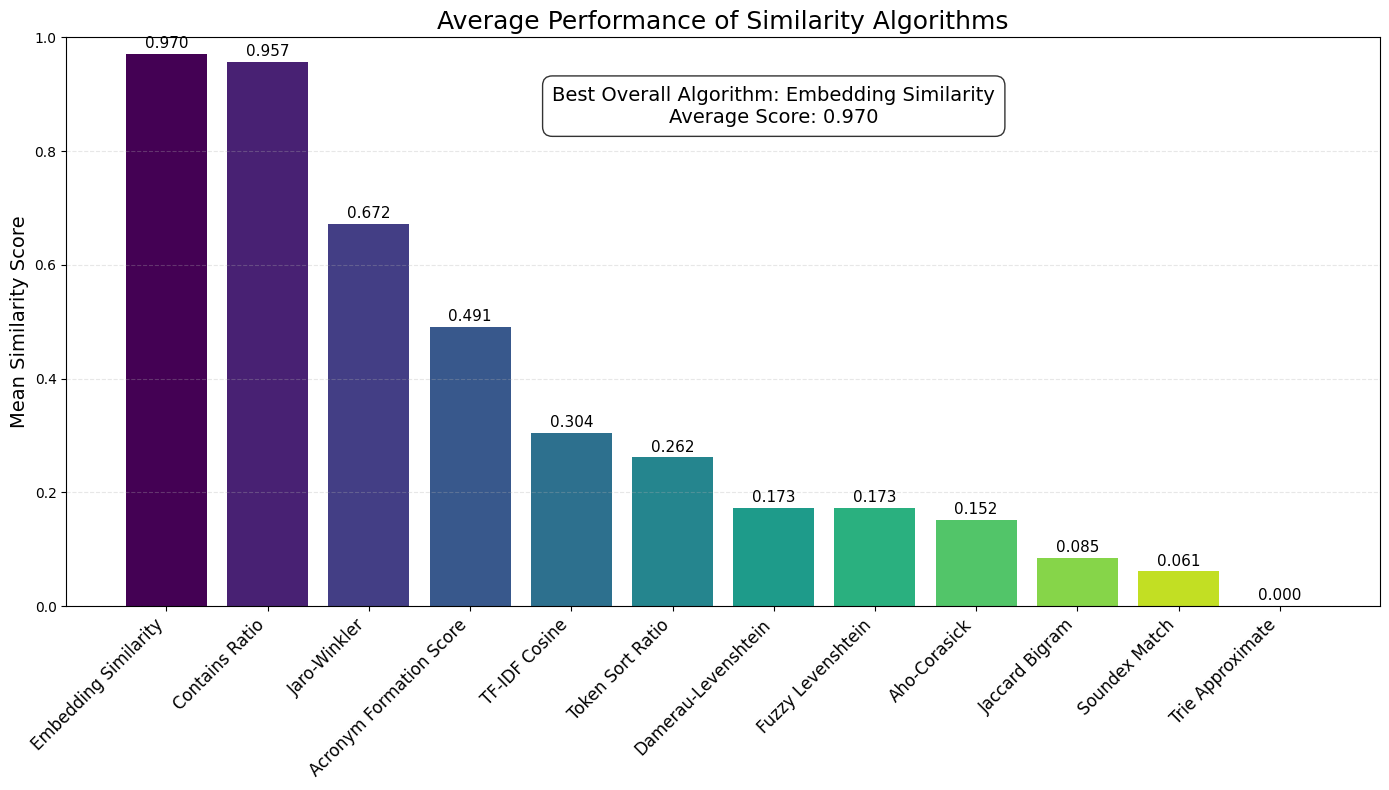


2. Detailed Analysis of Acronym Formation Score:


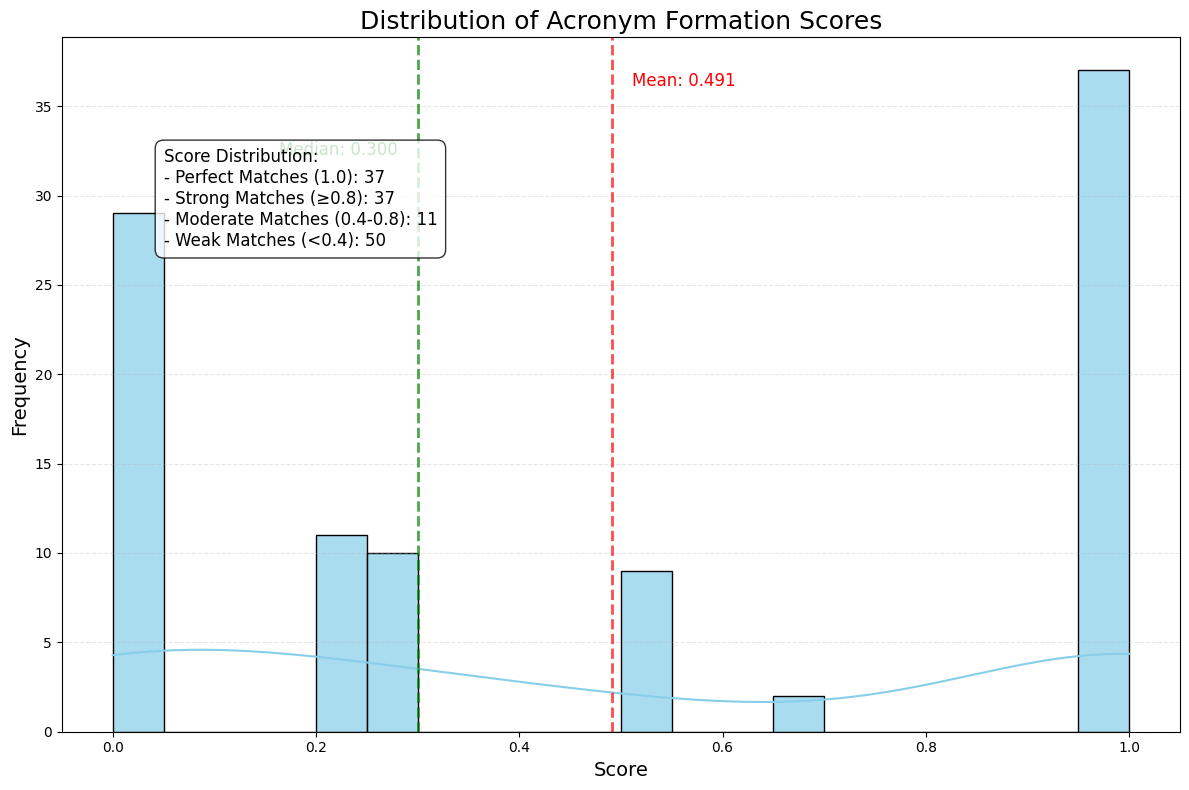


3. Case Study: McDonald's Acronym Variants:


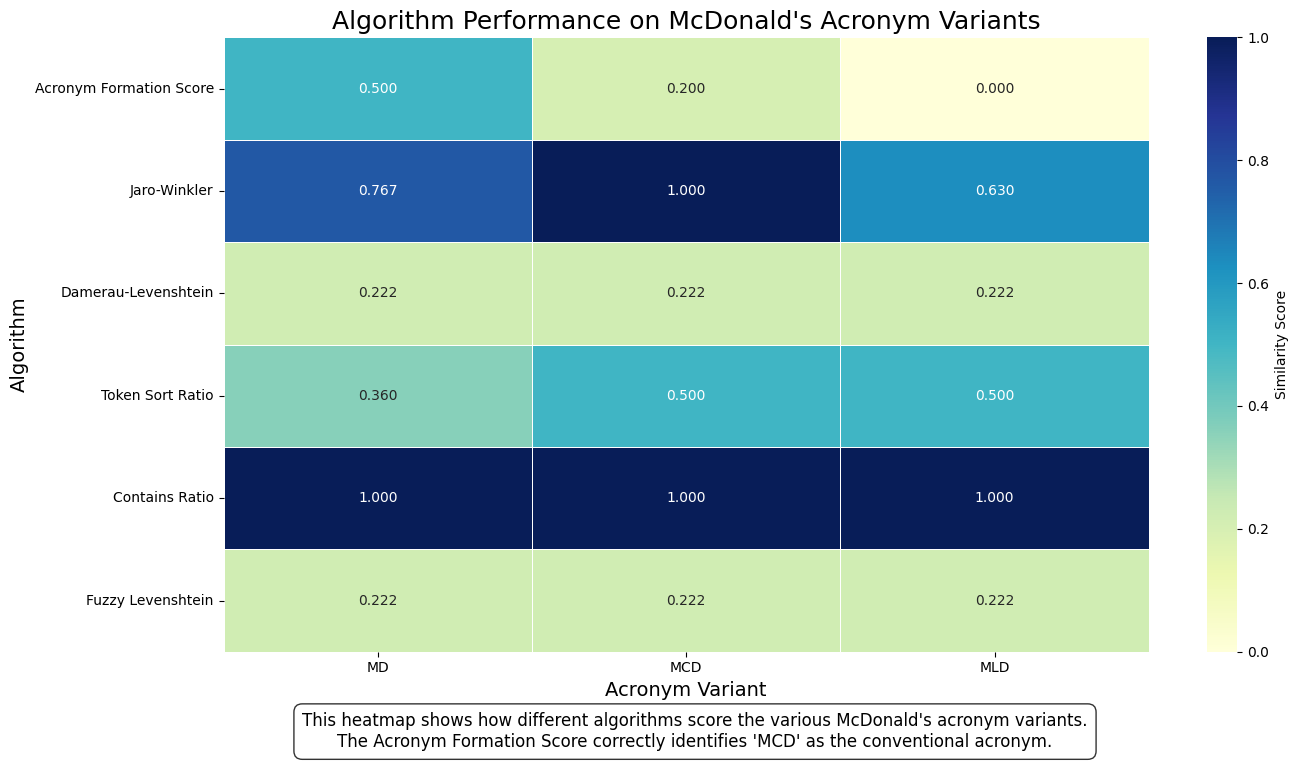


4. Algorithm Performance by Acronym Type:


<Figure size 1400x800 with 0 Axes>

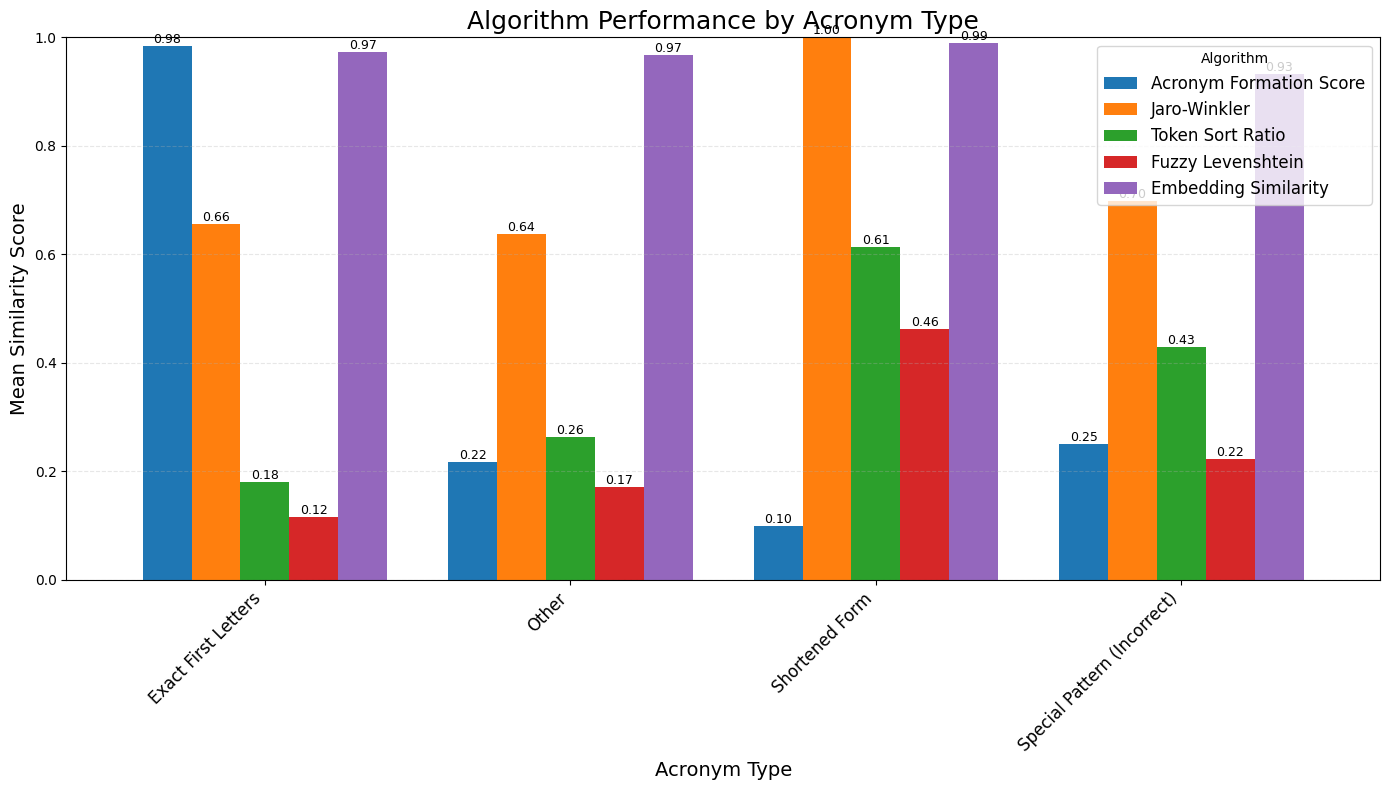


5. Distribution of Scores Across Algorithms:


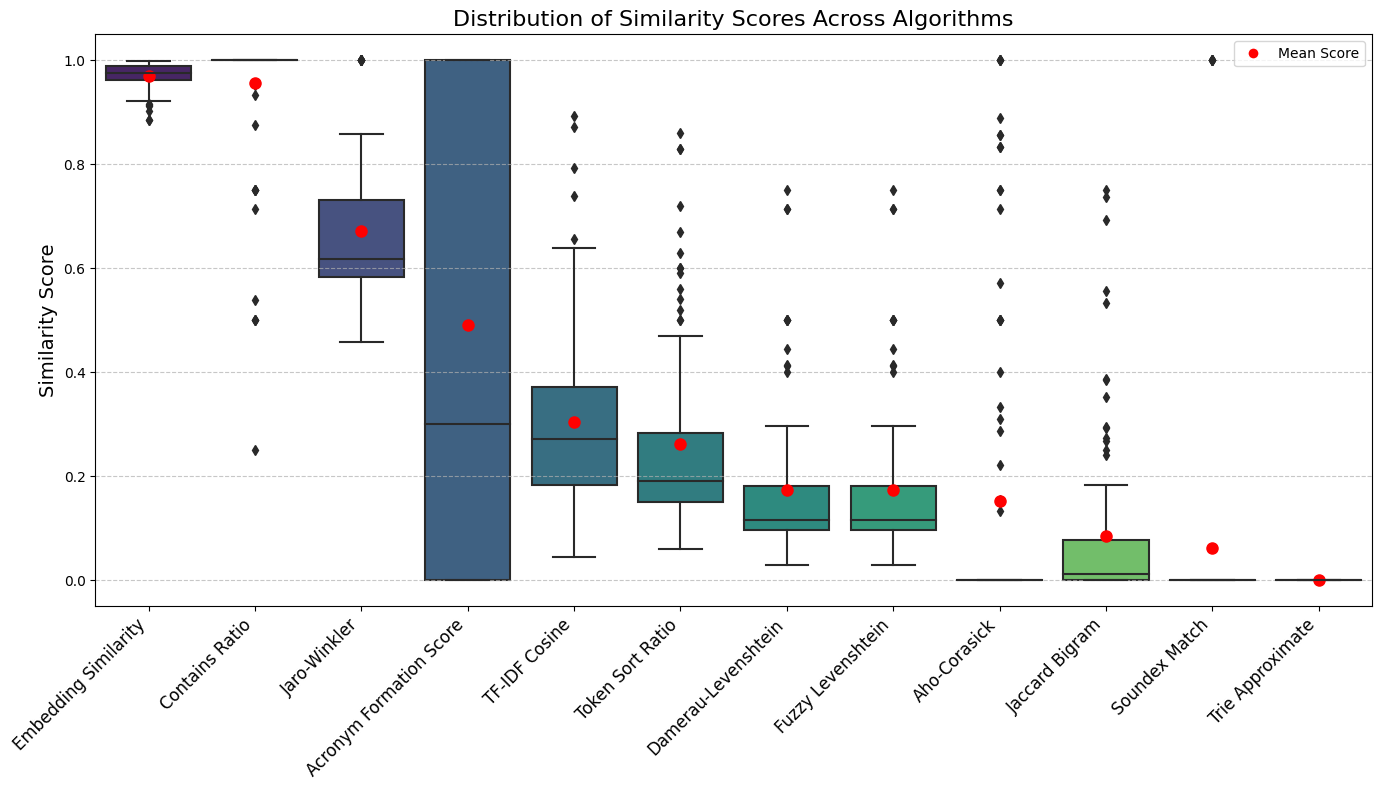


6. Correlation Between Different Algorithms:


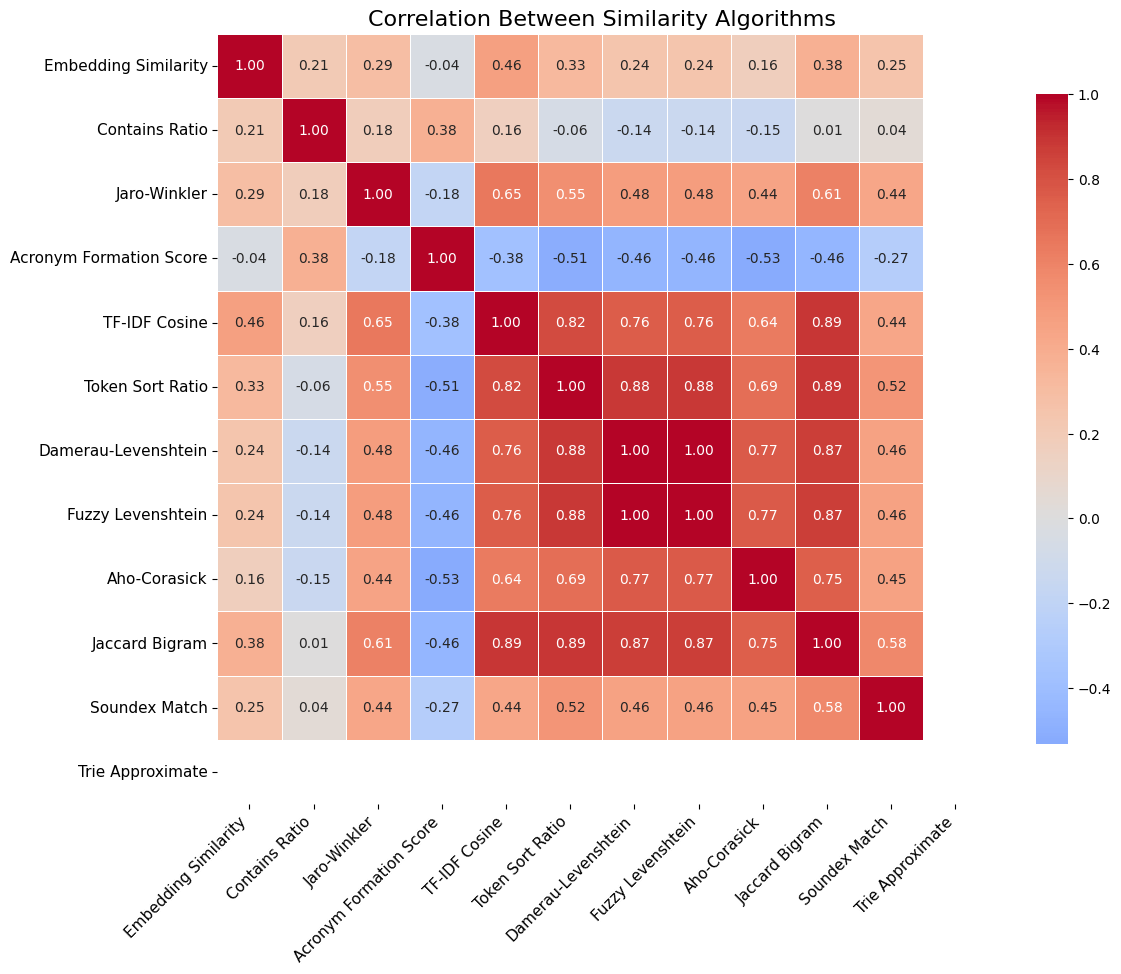


All visualizations displayed successfully.

=== COMPREHENSIVE ALGORITHM PERFORMANCE REPORT ===

SUMMARY STATISTICS:
       Jaro-Winkler  Damerau-Levenshtein  TF-IDF Cosine  Jaccard Bigram  \
count        98.000               98.000         98.000          98.000   
mean          0.672                0.173          0.304           0.085   
std           0.140                0.144          0.171           0.162   
min           0.458                0.029          0.044           0.000   
25%           0.583                0.097          0.184           0.000   
50%           0.617                0.115          0.272           0.011   
75%           0.731                0.180          0.372           0.077   
max           1.000                0.750          0.892           0.750   

       Soundex Match  Token Sort Ratio  Contains Ratio  Fuzzy Levenshtein  \
count         98.000            98.000          98.000             98.000   
mean           0.061             0.262           0.95

In [144]:
# Cell 12: Main Execution
if __name__ == '__main__':
    # Run full analysis
    result_df, performance_analysis = full_analysis()

In [74]:
pip install matplotlib seaborn pandas numpy networkx

Note: you may need to restart the kernel to use updated packages.
